In [ ]:
!pip install ccxt
!pip install pandas-ta
!pip install Backtesting
!pip install tensorflow
!pip install git+https://github.com/tensorflow/docs
!pip install optuna
!pip install optuna-dashboard
!pip uninstall bokeh
!pip install bokeh==3.1.0

In [ ]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots
from keras.regularizers import l2
from keras.layers import LSTM, Dropout, Dense, BatchNormalization, LayerNormalization, Input, Flatten
%load_ext tensorboard

import numpy as np
import pandas as pd
import pandas_ta as ta
from pandas_ta import ema,bbands,rsi
from collections import deque

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy.stats import norm
import optuna
import threading
from optuna_dashboard import run_server
import backtesting as bt
from backtesting import Backtest, Strategy

import ccxt
import os
import datetime
import time
import IPython
import IPython.display
from google.colab import files, drive, output


import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.figsize'] = (12, 6)
mpl.rcParams['axes.grid'] = False

#Fetch data


## Fetch functions

In [5]:
def fetch_ohlcv_multiple(exchange, symbol, timeframe, start_timestamp, end_timestamp, limit=300):
    ohlcv_list = []
    current_timestamp = start_timestamp
    while current_timestamp < end_timestamp:
        # Calculate the end timestamp for this request
        next_timestamp = min(current_timestamp + limit * 60 * 1000, end_timestamp)

        # Fetch OHLCV data
        ohlcv = exchange.fetch_ohlcv(symbol, timeframe=timeframe, since=current_timestamp, limit=limit)

        # Append the fetched data to the list
        ohlcv_list.extend(ohlcv)

        # Update the current timestamp for the next request
        current_timestamp = ohlcv[-1][0] + (ohlcv[-1][0] - ohlcv[-2][0])

        time.sleep(1)

    return ohlcv_list

def fetch_ohlcv_hourly(exchange, symbol, days=100):
    # Set the timeframe to 1 hour
    timeframe = '1h'

    # Calculate start and end timestamps
    end_timestamp = datetime.datetime.now().timestamp() * 1000
    start_timestamp = end_timestamp - (days * 24 * 60 * 60 * 1000)

    # Fetch OHLCV data (possibly in multiple requests)
    ohlcv = fetch_ohlcv_multiple(exchange, symbol, timeframe, start_timestamp, end_timestamp)

    # Convert the data to a Pandas DataFrame
    df = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])

    # Convert timestamp to a readable date format
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms', origin='unix')

    # Set timestamp as the index
    df.set_index('timestamp', inplace=True)

    return df

def fetch_ohlcv_5mins(exchange, symbol, days=100):
    # Set the timeframe to 5minutes
    timeframe = '5m'
    limit = 300

    # Calculate start and end timestamps
    end_timestamp = datetime.datetime.now().timestamp() * 1000
    start_timestamp = end_timestamp - (days * 24 * 60 * 60 * 1000)

    # Fetch OHLCV data (possibly in multiple requests)
    ohlcv = fetch_ohlcv_multiple(exchange, symbol, timeframe, start_timestamp, end_timestamp, limit)

    # Convert the data to a Pandas DataFrame
    df = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])

    # Convert timestamp to a readable date format
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms', origin='unix')

    # Set timestamp as the index
    df.set_index('timestamp', inplace=True)

    return df

def fetch_ohlcv_15mins(exchange, symbol, days=100):
    # Set the timeframe to 5minutes
    timeframe = '15m'
    limit = 300

    # Calculate start and end timestamps
    end_timestamp = datetime.datetime.now().timestamp() * 1000
    start_timestamp = end_timestamp - (days * 24 * 60 * 60 * 1000)

    # Fetch OHLCV data (possibly in multiple requests)
    ohlcv = fetch_ohlcv_multiple(exchange, symbol, timeframe, start_timestamp, end_timestamp, limit)

    # Convert the data to a Pandas DataFrame
    df = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])

    # Convert timestamp to a readable date format
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms', origin='unix')

    # Set timestamp as the index
    df.set_index('timestamp', inplace=True)

    return df

def getData(loadFromLocalStorage,csv_path):
  df_orig = []
  if(loadFromLocalStorage):
    df_orig = pd.read_csv(csv_path)
    # Set timestamp as the index
    df_orig.set_index('timestamp', inplace=True)
  else:
    exchange=ccxt.coinbase()
    symbol = "BTC/USDT"
    df_orig = fetch_ohlcv_15mins(exchange,symbol,1200)
    df_orig.to_csv(csv_path,index=True)

  return df_orig

## Fetch code

In [45]:
colabPath = '/content/drive/MyDrive/Colab Notebooks/MachineLearningPython/StockPrediction'
csv_path=os.path.join(colabPath, 'datasets/BTC_ohlcv_hourly.csv')

In [46]:
drive.mount('/content/drive')
loadFromLocalStorage = True

df_orig = getData(loadFromLocalStorage,csv_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data preprocessing

##Preprocessing functions

In [47]:
def BBANDS(data, n_lookback, n_std):
    """Bollinger bands indicator"""
    hlc3 = (data.High + data.Low + data.Close) / 3
    mean, std = hlc3.rolling(n_lookback).mean(), hlc3.rolling(n_lookback).std()
    upper = mean + n_std*std
    lower = mean - n_std*std
    return upper, lower

## Dataset

features  = ['Open','High','Low','Close','LogRet','RSI','EMA_10','EMA_50','MACD','ATR','Stochastic_Oscillator','BB_upper','BB_lower','BB_width','Volume_MA10','VWAP','Prev_Close_1','Prev_Close_2','Close_to_High','Close_to_Low']

target = ['Delta_Close_4']

In [48]:
# Get the Dataset from the original df
df = df_orig.rename(columns={
    'open': 'Open',
    'high': 'High',
    'low': 'Low',
    'close': 'Close',
    'volume': 'Volume'
})

df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Open,28796.0,40925.241883,18208.954435,15644.170000,26049.20000,38600.895000,57649.130000,99378.730000
High,28796.0,41081.656555,18282.506704,15761.300000,26094.21500,38779.155000,57924.925000,99750.000000
Low,28796.0,40762.178694,18132.609488,15477.170000,26002.88250,38441.090000,57398.927500,99002.210000
Close,28796.0,40926.460426,18211.762699,15653.240000,26049.27250,38602.245000,57651.990000,99373.280000
Volume,28796.0,34.893370,44.534851,0.009553,9.82098,20.393619,42.505656,1023.329662


In [49]:
future_steps = 4  # 1 hour ahead in 15-min intervals
# Price derived features
close=df.Close
low=df.Low
high=df.High
ema10 = ema(df.Close, length = 10)  # Fast
ema50 = ema(df.Close, length = 50) # Medium
ema12 = ema(df.Close, length = 12) # Medium
ema26 = ema(df.Close, length = 26) # Medium
upper, lower = BBANDS(df[['High','Low','Close']], 20, 2)

df['LogRet'] = np.log(df.Close / df.Close.shift(1))

df['RSI'] = rsi(df.Close, length = 14)
# Moving averages
# Price-derived features
df['EMA_10'] = (close - ema10)
df['EMA_50'] = (close - ema50)
df['MACD'] = (ema12-ema26)

# Volatility and Trend Indicators
df['ATR'] = ta.atr(high, low, close, length=14)
df['Stochastic_Oscillator'] = (close - low.rolling(window=14).min()) / (high.rolling(window=14).max() - low.rolling(window=14).min())
df['BB_upper'] = (upper - close)
df['BB_lower'] = (close - lower)
df['BB_width'] = (upper - lower)

# Volume-based Features
df['Volume_MA10'] = df['Volume'].rolling(window=10).mean()
df['VWAP'] = (df['Volume'] * (high + low + close) / 3).cumsum() / df['Volume'].cumsum()

# Lagged Features
df['Prev_Close_1'] = close.shift(4)  # 1 hour ago
df['Prev_Close_2'] = close.shift(8)  # 2 hours ago

# Close-to-High and Close-to-Low Ratios
df['Close_to_High'] = close / high
df['Close_to_Low'] = close / low


# Predicted value
df['Delta_Close_4'] = close.shift(-future_steps) - close
df = df.drop(columns=['Volume'])

#Split data to test and test data
df.dropna(inplace = True)

df.describe().transpose()


,count,mean,std,min,25%,50%,75%,max
Open,28743.0,40904.089648,18211.293552,15644.170000,26044.565000,38555.570000,57676.625000,99378.730000
High,28743.0,41060.419275,18284.926899,15761.300000,26086.600000,38741.910000,57947.725000,99750.000000
Low,28743.0,40741.155022,18135.040882,15477.170000,25995.585000,38387.890000,57423.595000,99002.210000
Close,28743.0,40905.302096,18214.235153,15653.240000,26044.065000,38551.590000,57676.340000,99373.280000
LogRet,28743.0,0.000023,0.005881,-0.073103,-0.002195,0.000042,0.002338,0.062791
RSI,28743.0,50.498265,12.158035,6.335212,42.857186,50.431656,57.937056,92.658687
EMA_10,28743.0,7.480616,366.621110,-4347.570997,-106.862638,3.673584,123.339837,3367.516199
EMA_50,28743.0,40.868545,896.363559,-7619.742568,-302.664300,12.903694,398.518326,6976.913503
MACD,28743.0,11.691958,293.341088,-2356.394886,-96.725415,4.194731,123.292855,2172.921324
ATR,28743.0,320.003584,212.317532,17.903392,156.113644,276.431795,441.280324,1630.041385


###Split and scale the data

In [50]:
count_df = len(df.columns)

In [51]:
df.reset_index(inplace = True)
# Define split indices for train, validation, and test
train_idx = int(len(df) * 0.7)
val_idx = int(len(df) * 0.9)

backtest_df = df[val_idx:]
backtest_df.reset_index(inplace = True)
backtest_df = backtest_df.drop(columns=['index'])
backtest_df.set_index('timestamp', inplace=True)

df = df.drop(columns=['timestamp'])

df.head()

,Open,High,Low,Close,LogRet,RSI,EMA_10,EMA_50,MACD,ATR,...,BB_upper,BB_lower,BB_width,Volume_MA10,VWAP,Prev_Close_1,Prev_Close_2,Close_to_High,Close_to_Low,Delta_Close_4
0,49138.32,49310.19,48833.60,48874.74,-0.004970,47.068954,-197.687357,-18.763200,44.205293,350.471229,...,632.398761,159.553428,791.952188,7.558309,48909.950503,49063.45,49118.69,0.991169,1.000842,-263.38
1,48869.28,49000.00,48671.66,48872.28,-0.000050,47.015996,-163.756929,-20.390918,24.837428,348.850574,...,534.575041,133.572375,668.147416,9.224695,48908.760607,49213.82,49160.87,0.997393,1.004122,-189.24
2,48844.41,48954.58,48165.42,48207.49,-0.013696,35.418557,-677.902033,-658.311078,-43.651555,381.036172,...,1203.929266,-424.433401,779.495865,12.409834,48893.072959,49152.96,49188.77,0.984739,1.000873,185.56
3,48182.09,48532.70,48050.00,48523.77,0.006539,42.664753,-295.872572,-328.618094,-71.583246,388.455179,...,948.520163,22.933163,971.453326,14.142496,48881.620902,49118.25,49190.19,0.999816,1.009860,104.48
4,48511.11,48830.18,48369.97,48611.36,0.001803,44.521259,-170.413014,-231.576012,-85.664051,393.683460,...,870.179571,159.503571,1029.683143,14.653327,48878.693621,48874.74,49063.45,0.995519,1.004990,-235.14


In [ ]:
backtest_df.head()

,Open,High,Low,Close,LogRet,RSI,EMA_10,EMA_50,MACD,ATR,...,BB_upper,BB_lower,BB_width,Volume_MA10,VWAP,Prev_Close_1,Prev_Close_2,Close_to_High,Close_to_Low,Delta_Close_4
timestamp,,,,,,,,,,,,,,,,,,,,,
2024-07-06 13:45:00,56826.94,57308.22,56816.64,56962.04,0.002451,65.436570,188.927303,374.272417,75.901798,146.487527,...,-19.991025,490.597975,470.606950,4.578625,33539.635549,56767.28,56737.99,0.993959,1.002559,101.31
2024-07-06 14:00:00,56996.43,57104.84,56722.85,56749.07,-0.003746,53.120871,-19.671297,154.976832,69.499630,163.309132,...,201.743237,252.330570,454.073806,5.489098,33539.868071,56716.84,56705.29,0.993770,1.000462,236.45
2024-07-06 14:15:00,56761.39,56850.57,56758.56,56830.04,0.001426,56.474914,50.153484,226.694015,70.150813,158.894194,...,110.860956,290.814289,401.675244,5.850761,33539.992716,56769.87,56685.96,0.999639,1.001259,405.76
2024-07-06 14:30:00,56852.76,57034.14,56818.61,56977.29,0.002588,61.824169,161.511941,359.279544,81.607999,162.939609,...,-28.660289,401.361378,372.701089,6.343898,33540.122482,56822.62,56608.60,0.999003,1.002793,369.67
2024-07-06 14:45:00,56941.58,57125.89,56904.40,57063.35,0.001509,64.565203,202.558861,427.875248,96.519606,167.121779,...,-66.026811,501.351189,435.324378,6.790793,33540.253492,56962.04,56767.28,0.998905,1.002793,239.60


(20120, 21)
(5748, 21)
(2875, 21)


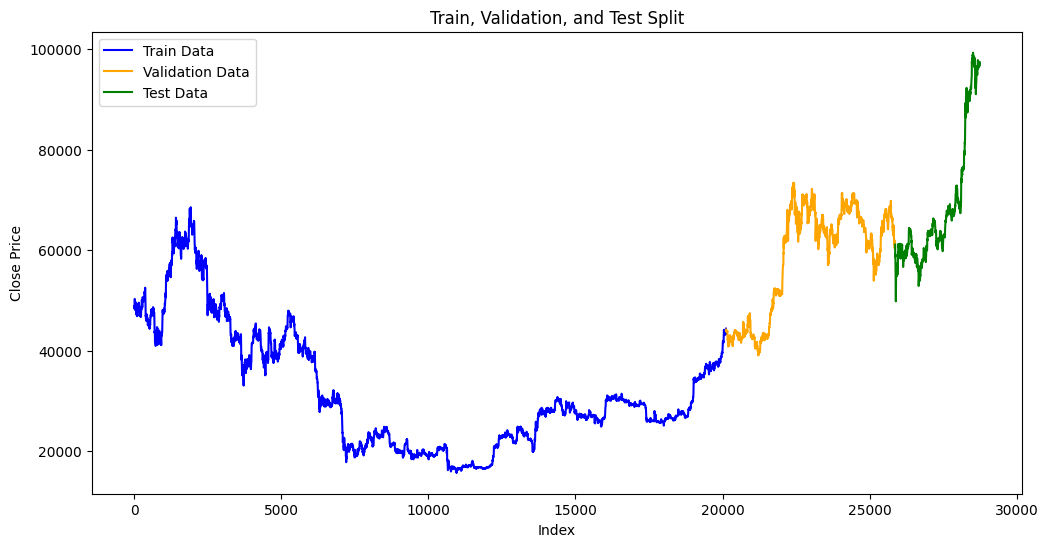

In [52]:
# Split data
train_data = df[:train_idx]
val_data = df[train_idx:val_idx]
test_data = df[val_idx:]

print(train_data.shape)
print(val_data.shape)
print(test_data.shape)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(train_data[::4]['Close'], label='Train Data', color='blue')
plt.plot(val_data[::4]['Close'], label='Validation Data', color='orange')
plt.plot(test_data[::4]['Close'], label='Test Data', color='green')
plt.xlabel('Index')
plt.ylabel('Close Price')
plt.title('Train, Validation, and Test Split')
plt.legend()
plt.show()

In [53]:
# Scalers
df_columns_to_scale = ['Open','High','Low','Close','LogRet','RSI','EMA_10','EMA_50','MACD','ATR','Stochastic_Oscillator','BB_upper','BB_lower','BB_width','Volume_MA10','VWAP','Prev_Close_1','Prev_Close_2','Close_to_High','Close_to_Low']
sc = MinMaxScaler(feature_range=(0,1))
sc_y = StandardScaler()

In [54]:
train_df = train_data.copy()
val_df = val_data.copy()
test_df = test_data.copy()

train_df[df_columns_to_scale] = sc.fit_transform(train_df[df_columns_to_scale])
train_df['Delta_Close_4'] = sc_y.fit_transform(train_df[['Delta_Close_4']])
scaled_train_df = train_df.iloc[:, 0:count_df].values

val_df[df_columns_to_scale] = sc.transform(val_df[df_columns_to_scale])
val_df['Delta_Close_4'] = sc_y.transform(val_df[['Delta_Close_4']])
scaled_val_df = val_df.iloc[:, 0:count_df].values

test_df[df_columns_to_scale] = sc.transform(test_df[df_columns_to_scale])
test_df['Delta_Close_4'] = sc_y.transform(test_df[['Delta_Close_4']])
scaled_test_df = test_df.iloc[:, 0:count_df].values

train_df.describe().transpose()



,count,mean,std,min,25%,50%,75%,max
Open,20120.0,0.308228,0.227116,0.000000,0.129517,0.244787,0.464887,1.000000
High,20120.0,0.306883,0.227182,0.000000,0.129100,0.244155,0.463360,1.000000
Low,20120.0,0.309015,0.225926,0.000000,0.131084,0.246049,0.464635,1.000000
Close,20120.0,0.308101,0.227150,0.000000,0.129345,0.244692,0.464829,1.000000
LogRet,20120.0,0.537903,0.044316,0.000000,0.521878,0.538200,0.554473,1.000000
RSI,20120.0,0.507034,0.141405,0.000000,0.419061,0.505377,0.592440,1.000000
EMA_10,20120.0,0.652320,0.045402,0.000000,0.639247,0.652567,0.666137,1.000000
EMA_50,20120.0,0.633527,0.063009,0.000000,0.611928,0.633794,0.658172,1.000000
MACD,20120.0,0.649601,0.067357,0.000000,0.627051,0.650102,0.674016,1.000000
ATR,20120.0,0.167000,0.122553,0.000000,0.077046,0.125928,0.235186,1.000000


In [ ]:
val_df.describe().transpose()

In [ ]:
test_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Open,11498.0,0.881064,0.079931,0.642197,0.818129,0.879150,0.946598,1.090837
High,11498.0,0.877942,0.079333,0.648402,0.815095,0.875835,0.943005,1.086563
Low,11498.0,0.883351,0.080277,0.632733,0.820167,0.881865,0.949263,1.088356
Close,11498.0,0.881228,0.079954,0.642497,0.818218,0.879496,0.946650,1.090933
LogRet,11498.0,0.628781,0.018057,0.356480,0.620703,0.628827,0.637167,0.836454
RSI,11498.0,0.512370,0.120548,0.059546,0.433723,0.514119,0.591001,0.892074
EMA_10,11498.0,0.683703,0.032378,0.260127,0.670240,0.684282,0.697936,0.982053
EMA_50,11498.0,0.688879,0.050896,0.169533,0.665252,0.689879,0.713419,0.965100
MACD,11498.0,0.620302,0.067656,0.093016,0.589858,0.620759,0.652285,0.917165
ATR,11498.0,0.157142,0.079417,0.030444,0.108186,0.145540,0.189864,0.885833


In [55]:
# Prepare the data for LSTM layers
# Define the number of 15-minute intervals
backcandles = 32  # 8 hours of 15-min intervals
label_index = train_df.columns.get_loc('Delta_Close_4')
# Update the feature preparation
X_train = np.array([scaled_train_df[i-backcandles:i, : label_index].copy() for i in range(backcandles, len(scaled_train_df)-future_steps+1)])
y_train = np.array(scaled_train_df[backcandles-1:-future_steps, label_index])
Y_train = np.reshape(y_train, (len(y_train), 1))

X_validation = np.array([scaled_val_df[i-backcandles:i, : label_index].copy() for i in range(backcandles, len(scaled_val_df)-future_steps+1)])
yi_val = np.array(scaled_val_df[backcandles-1:-future_steps,  label_index])
Y_validation = np.reshape(yi_val, (len(yi_val), 1))

X_test = np.array([scaled_test_df[i-backcandles:i, : label_index].copy() for i in range(backcandles, len(scaled_test_df)-future_steps+1)])
yi_test = np.array(scaled_test_df[backcandles-1:-future_steps,  label_index])
Y_test = np.reshape(yi_test, (len(yi_test), 1))

print(f"X_train shape: {X_train.shape}")
print(f"X_validation shape: {X_validation.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"Y_train shape: {Y_train.shape}")
print(f"Y_validation shape: {Y_validation.shape}")
print(f"Y_test shape: {Y_test.shape}")

X_train shape: (20085, 32, 20)
X_validation shape: (5713, 32, 20)
X_test shape: (2840, 32, 20)
Y_train shape: (20085, 1)
Y_validation shape: (5713, 1)
Y_test shape: (2840, 1)


In [ ]:
print(Y_train[-1])
print(scaled_train_df[-5,train_df.columns.get_loc('Delta_Close_4')])

[-1.57448291]
-1.574482911427934


#Creating and training the model

In [63]:
local_directory  = os.path.join(colabPath, "lstm_dcp/model_v1.keras")
checkpoint_path = os.path.join(colabPath, "lstm_dcp/training_BTC_dc4/best_checkpoint.weights.h5")

## Calculate step sizes

In [57]:
BATCH_SIZE = 64
N_TRAIN = X_train.shape[0]
EPOCHS = 50
metrics=[keras.metrics.MeanAbsoluteError(),keras.metrics.RootMeanSquaredError(),keras.metrics.R2Score()]

##Funtions

In [58]:
def get_callbacks(checkpoint_path):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=5,
                                                    mode='min',restore_best_weights=True)

  # Create a callback that saves the model's weights
  cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                  save_best_only = True,
                                                  save_weights_only=True,
                                                  monitor='val_loss',
                                                  mode='min')

  reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

  return [early_stopping, cp_callback, reduce_lr]

In [59]:
def compile_and_fit(layers, loss_fn, optimizer, metrics, checkpoint_path):
  model = layers
  model.compile(loss= loss_fn,
                optimizer= optimizer,
                metrics= metrics)
  model.summary()
  history = model.fit(X_train, Y_train, epochs=EPOCHS, validation_data=(X_validation, Y_validation),callbacks=get_callbacks(checkpoint_path), batch_size=BATCH_SIZE)

  return model,history

def compile_and_load_latest_weights(model, loss_fn, optimizer, metrics, checkpoint_path):
  model.compile(loss=loss_fn,
                optimizer=optimizer,
                metrics=metrics)
  model.summary()
  # Load the latest weight for the model.
  model.load_weights(checkpoint_path)

  return model

def plot_model_history(name, history, metric):
  plotter = tfdocs.plots.HistoryPlotter(metric = metric, smoothing_std=10)
  plotter.plot(history)
  a = plt.xscale('log')
  plt.xlim([5, max(plt.xlim())])
  plt.ylim([0.5, 0.7])
  plt.xlabel("Epochs [Log Scale]")

def save_model(model, filepath):
  model.save(filepath)

def load_model(filepath):
  # Load the model if available
  model = tf.keras.models.load_model(filepath)
  return model

## Load trained model

In [60]:
model = tf.keras.models.load_model(local_directory)

# Show the model architecture
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                       │ (64, 32, 30)                │           6,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization_12               │ (64, 32, 30)                │              60 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (64, 32, 30)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_13 (LSTM)                       │ (64, 32, 30)                │           7,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization_13               │ (64, 32, 30)                │              60 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (64, 32, 30)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_14 (LSTM)                       │ (64, 30)                    │           7,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization_14               │ (64, 30)                    │              60 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (64, 30)                    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (64, 1)                     │              31 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 62,914 (245.76 KB)

 Trainable params: 20,971 (81.92 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 41,943 (163.84 KB)

## Layers of the model

In [68]:
layers = tf.keras.Sequential([
    Input((backcandles,count_df-1),BATCH_SIZE ),
    LSTM(90, return_sequences=False, kernel_regularizer=l2(0.0001), recurrent_dropout=0.1),
    LayerNormalization(),
    Dropout(0.25),

    Dense(1)
])

# loss function for distributions
loss= 'mean_absolute_error'

opt = tf.keras.optimizers.Adam(learning_rate=0.0005,weight_decay=0.85)

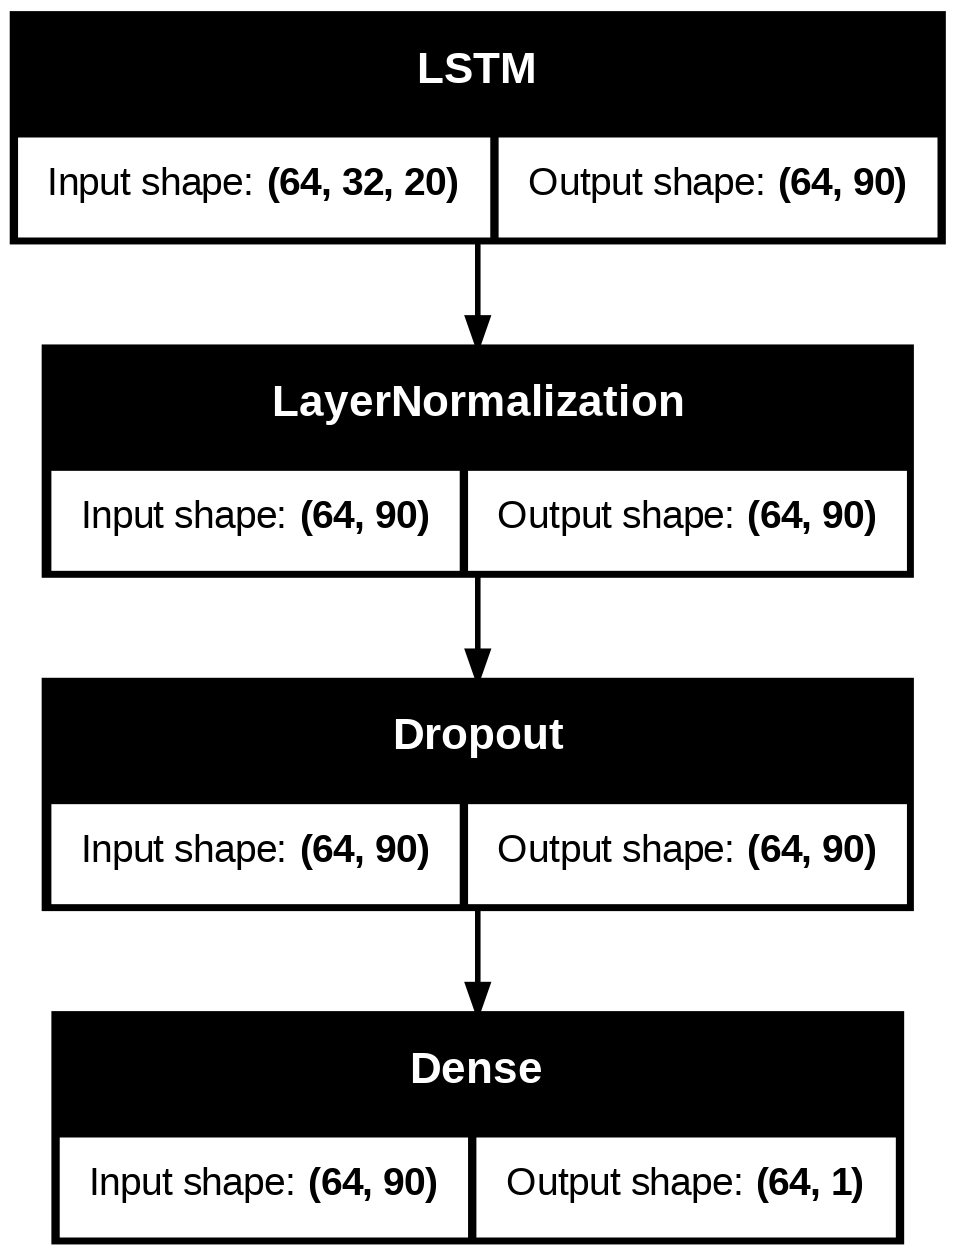

In [26]:
tf.keras.utils.plot_model(layers, show_shapes=True)

## Load weights from checkpoints

In [69]:
model = compile_and_load_latest_weights(layers, loss, opt, metrics, checkpoint_path)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (64, 90)                    │          39,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization_2                │ (64, 90)                    │             180 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (64, 90)                    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (64, 1)                     │              91 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 40,231 (157.15 KB)

 Trainable params: 40,231 (157.15 KB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 16 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


##Train model

In [157]:
model,history = compile_and_fit(layers, loss, opt,metrics, checkpoint_path)

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_18 (LSTM)                       │ (64, 32, 30)                │           6,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization_18               │ (64, 32, 30)                │              60 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (64, 32, 30)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_19 (LSTM)                       │ (64, 30)                    │           7,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization_19               │ (64, 30)                    │              60 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (64, 30)                    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (64, 1)                     │              31 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 40,775 (159.28 KB)

 Trainable params: 13,591 (53.09 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 27,184 (106.19 KB)

Epoch 1/50
314/314 ━━━━━━━━━━━━━━━━━━━━ 23s 62ms/step - loss: 0.8228 - mean_absolute_error: 0.8151 - r2_score: -0.3893 - root_mean_squared_error: 1.1862 - val_loss: 0.7402 - val_mean_absolute_error: 0.7340 - val_r2_score: -0.0043 - val_root_mean_squared_error: 1.1581 - learning_rate: 5.0000e-04
Epoch 2/50
314/314 ━━━━━━━━━━━━━━━━━━━━ 20s 59ms/step - loss: 0.6217 - mean_absolute_error: 0.6158 - r2_score: -0.0296 - root_mean_squared_error: 1.0042 - val_loss: 0.7371 - val_mean_absolute_error: 0.7324 - val_r2_score: -0.0019 - val_root_mean_squared_error: 1.1567 - learning_rate: 5.0000e-04
Epoch 3/50
314/314 ━━━━━━━━━━━━━━━━━━━━ 18s 57ms/step - loss: 0.6027 - mean_absolute_error: 0.5984 - r2_score: -0.0088 - root_mean_squared_error: 1.0001 - val_loss: 0.7353 - val_mean_absolute_error: 0.7318 - val_r2_score: 1.2279e-04 - val_root_mean_squared_error: 1.1555 - learning_rate: 5.0000e-04
Epoch 4/50
314/314 ━━━━━━━━━━━━━━━━━━━━ 20s 55ms/step - loss: 0.5892 - mean_absolute_error: 0.5860 - r2_score

## Evaluate model on test data

In [70]:
performance = model.evaluate(X_test, Y_test,return_dict=True)
val_performance = model.evaluate(X_validation, Y_validation,return_dict=True)

89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 1.0961 - mean_absolute_error: 1.0960 - r2_score: -0.0064 - root_mean_squared_error: 1.5879
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.8860 - mean_absolute_error: 0.8859 - r2_score: -0.0051 - root_mean_squared_error: 1.3655


In [71]:
performance

{'loss': 1.1383038759231567,
 'mean_absolute_error': 1.1382149457931519,
 'r2_score': -0.004446148872375488,
 'root_mean_squared_error': 1.695493459701538}

## Save model

In [224]:
model.save(local_directory)

Converting model to onnx format

In [ ]:
##input_signature = [tf.TensorSpec([None,backcandles,15],tf.float32, name='x')]

##onnx_model, _ =tf2onnx.convert.from_keras(model,input_signature=input_signature)
##onnx.save(onnx_model,"predictormodel.onnx")

# Predict output

In [72]:
## Predict Single output for Delta price
single_sample = X_test[1000:1001]
prediction = model(tf.convert_to_tensor(single_sample))
prediction = sc_y.inverse_transform(prediction)
print('Predicted price:',prediction[0][0])
print('Original price:',backtest_df[backcandles-1+1000:backcandles+1000]['Delta_Close_4'])

Predicted price: 20.156172593737832
Original price: timestamp
2024-09-16 11:00:00   -795.85
Name: Delta_Close_4, dtype: float64


In [73]:
# Predict multiple output for Delta Price
predictions = model(X_test)

# Inverse transform predictions using sc_y without padding
inversed_predictions = sc_y.inverse_transform(predictions)
inversed_predictions = inversed_predictions[:, 0]

inversed_predictions_df = pd.DataFrame(inversed_predictions, columns=['Predicted_Delta_Close_4'])

# Get actual values from backtest_df
actuals = backtest_df.iloc[backcandles-1:backcandles-1+len(X_test)]['Delta_Close_4'].values

# Calculate the direction of predicted and actual values
predicted_directions = np.sign(inversed_predictions)
actual_directions = np.sign(actuals)

# Calculate correct and incorrect predictions
correct_predictions = np.sum(predicted_directions == actual_directions)
incorrect_predictions = len(predicted_directions) - correct_predictions

# Calculate accuracy
accuracy = correct_predictions / len(predicted_directions)

results = predicted_directions == actual_directions;

In [163]:
# Identify correct and incorrect predictions
correct_mask = (predicted_directions == actual_directions)
incorrect_mask = ~correct_mask

# Calculate differences for correct and incorrect predictions
correct_diffs = np.abs(inversed_predictions[correct_mask] - actuals[correct_mask])
incorrect_diffs = np.abs(inversed_predictions[incorrect_mask] - actuals[incorrect_mask])

# Calculate the mean differences
mean_correct_diff = correct_diffs.mean() if len(correct_diffs) > 0 else 0
mean_incorrect_diff = incorrect_diffs.mean() if len(incorrect_diffs) > 0 else 0

# Calculate standard deviation for correct and incorrect predictions
std_correct_diff = correct_diffs.std() if len(correct_diffs) > 0 else 0
std_incorrect_diff = incorrect_diffs.std() if len(incorrect_diffs) > 0 else 0

# Generate Gaussian distributions
x_correct = np.linspace(mean_correct_diff - 3*std_correct_diff, mean_correct_diff + 3*std_correct_diff, 1000)
y_correct = norm.pdf(x_correct, mean_correct_diff, std_correct_diff)

x_incorrect = np.linspace(mean_incorrect_diff - 3*std_incorrect_diff, mean_incorrect_diff + 3*std_incorrect_diff, 1000)
y_incorrect = norm.pdf(x_incorrect, mean_incorrect_diff, std_incorrect_diff)

#### Plot prediction

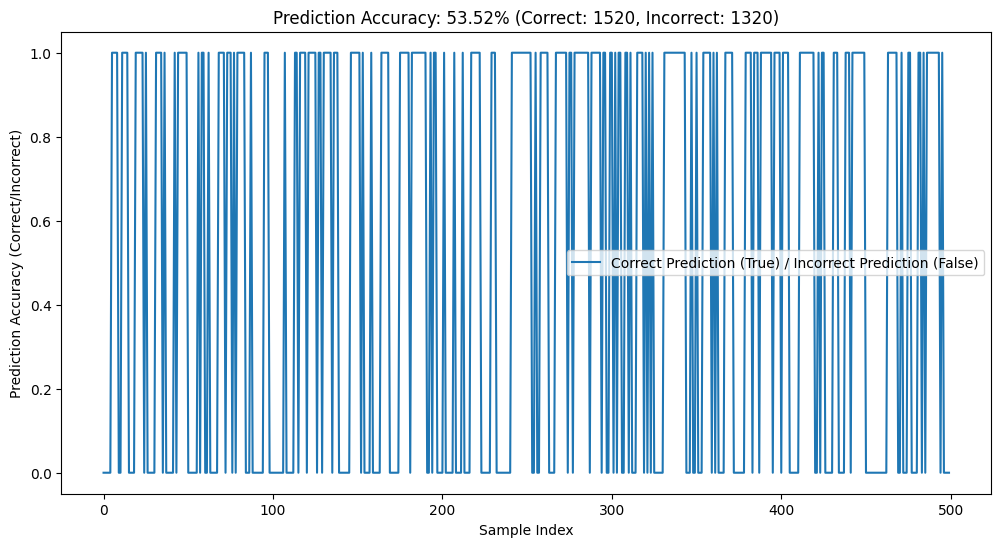

Correct predictions: 1520
Incorrect predictions: 1320
Prediction accuracy: 53.52%


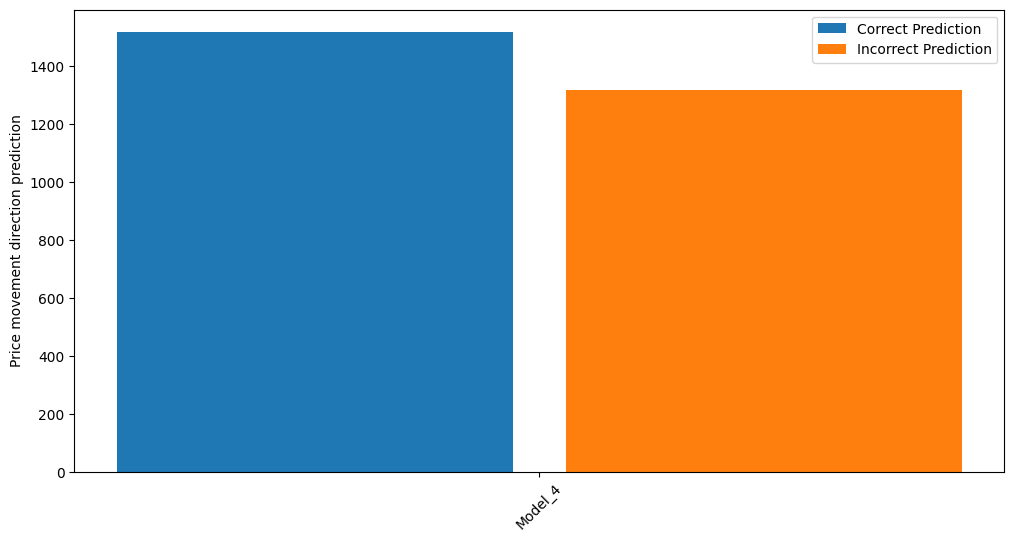

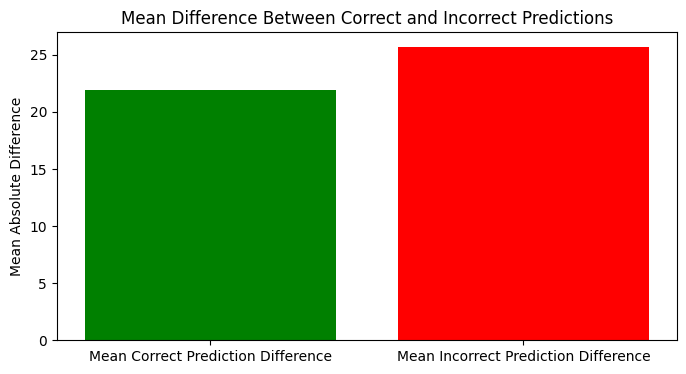

In [164]:
# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(results[500:1000], label="Correct Prediction (True) / Incorrect Prediction (False)")
plt.xlabel("Sample Index")
plt.ylabel("Prediction Accuracy (Correct/Incorrect)")
plt.title(f"Prediction Accuracy: {accuracy:.2%} (Correct: {correct_predictions}, Incorrect: {incorrect_predictions})")
plt.legend()
plt.show()

print(f"Correct predictions: {correct_predictions}")
print(f"Incorrect predictions: {incorrect_predictions}")
print(f"Prediction accuracy: {accuracy:.2%}")
width = 0.3
x= np.arange(1)
plt.figure(figsize=(12, 6))
plt.ylabel('Price movement direction prediction')
plt.bar(x - 0.17, correct_predictions, width, label='Correct Prediction')
plt.bar(x + 0.17, incorrect_predictions, width, label='Incorrect Prediction')

plt.xticks(ticks=x, labels=['Model_4'],
           rotation=45)
_ = plt.legend()

# Plotting the results
plt.figure(figsize=(8, 4))
plt.bar(['Mean Correct Prediction Difference', 'Mean Incorrect Prediction Difference'], [mean_correct_diff, mean_incorrect_diff], color=['green', 'red'])
plt.ylabel("Mean Absolute Difference")
plt.title("Mean Difference Between Correct and Incorrect Predictions")
plt.show()

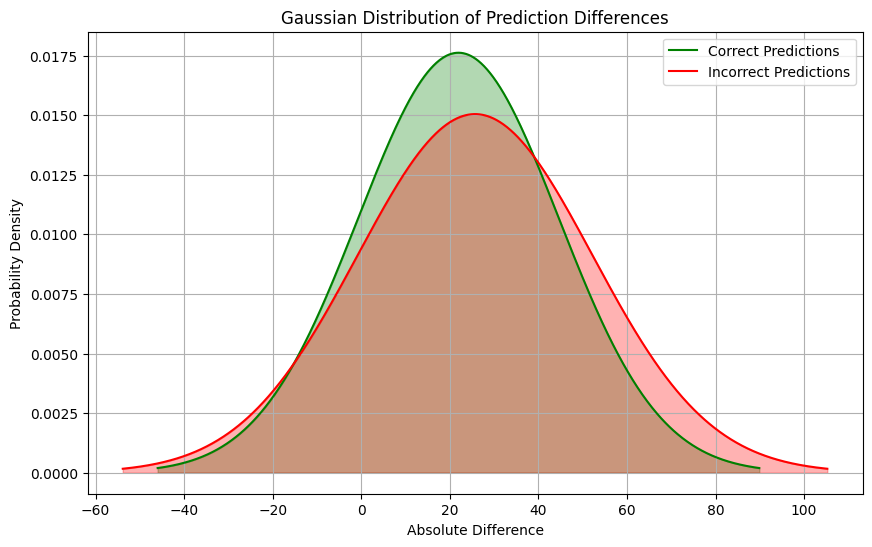

In [165]:
# Plot the distributions
plt.figure(figsize=(10, 6))
plt.plot(x_correct, y_correct, label="Correct Predictions", color="green")
plt.plot(x_incorrect, y_incorrect, label="Incorrect Predictions", color="red")
plt.fill_between(x_correct, y_correct, alpha=0.3, color="green")
plt.fill_between(x_incorrect, y_incorrect, alpha=0.3, color="red")

# Add labels and legend
plt.xlabel("Absolute Difference")
plt.ylabel("Probability Density")
plt.title("Gaussian Distribution of Prediction Differences")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
X_train.shape[1:]

(32, 20)

# Optimize model

In [22]:
def create_model(trial, lstm_layers, input_shape):
    weight_decay = trial.suggest_float("weight_decay", 1e-10, 1e-3, log=True)
    model = tf.keras.Sequential()
    model.add(Input(input_shape))

    for i in range(lstm_layers):
        num_hidden = trial.suggest_int(f"n_units_l{i}", 20, 120, log=True)
        model.add(
            LSTM(
                num_hidden,
                activation="relu",
                return_sequences=(i < lstm_layers - 1),
                kernel_regularizer=tf.keras.regularizers.l2(weight_decay),
            )
        )
        model.add(LayerNormalization())
        dropout_rate = trial.suggest_float(f"dropout_rate_l{i}", 0.1, 0.5)
        model.add(Dropout(dropout_rate))

    model.add(Dense(1, kernel_regularizer=tf.keras.regularizers.l2(weight_decay)))
    return model


def create_optimizer(trial):
    # We optimize the choice of optimizers as well as their parameters.
    kwargs = {}
    optimizer_options = ["RMSprop", "Adam", "SGD"]
    optimizer_selected = trial.suggest_categorical("optimizer", optimizer_options)
    if optimizer_selected == "RMSprop":
        kwargs["learning_rate"] = trial.suggest_float(
            "rmsprop_learning_rate", 1e-5, 1e-1, log=True
        )
        kwargs["weight_decay"] = trial.suggest_float("rmsprop_weight_decay", 0.85, 0.99)
        kwargs["momentum"] = trial.suggest_float("rmsprop_momentum", 1e-5, 1e-1, log=True)
    elif optimizer_selected == "Adam":
        kwargs["learning_rate"] = trial.suggest_float("adam_learning_rate", 1e-5, 1e-1, log=True)
    elif optimizer_selected == "SGD":
        kwargs["learning_rate"] = trial.suggest_float(
            "sgd_opt_learning_rate", 1e-5, 1e-1, log=True
        )
        kwargs["momentum"] = trial.suggest_float("sgd_opt_momentum", 1e-5, 1e-1, log=True)

    optimizer = getattr(tf.optimizers, optimizer_selected)(**kwargs)
    return optimizer

def objective(trial):
    # Suggest hyperparameters
    lstm_layers = trial.suggest_int("lstm_layers", 1, 3)

    # Define the model
    input_shape = X_train.shape[1:]  # Shape of each sample (timesteps, features)
    model = create_model(trial, lstm_layers, input_shape)
    optimizer = create_optimizer(trial)

    # Compile the model
    model.compile(optimizer=optimizer, loss="mean_absolute_error", metrics=["mean_absolute_error"])

    # Train the model
    history = model.fit(
        X_train, Y_train, epochs=20, validation_data=(X_validation, Y_validation),callbacks=get_callbacks(checkpoint_path),  batch_size=BATCH_SIZE
    )

    # Evaluate the model on the validation set
    val_loss = history.history["val_mean_absolute_error"][-1]
    return val_loss  # Return validation MAE as the objective value

# Run optimization
storage = optuna.storages.InMemoryStorage()
study = optuna.create_study(storage=storage, direction='minimize')
study.optimize(objective, n_trials=30)

# Start Optuna Dashboard
port = 8082
thread = threading.Thread(target=run_server, args=(storage,), kwargs={"port": port})
thread.start()
output.serve_kernel_port_as_window(port, path='/dashboard/')

[I 2024-12-05 10:44:55,311] A new study created in memory with name: no-name-bc763a5d-decd-4081-a74b-7fb5a5e3e281


Epoch 1/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 85s 89ms/step - loss: 0.7529 - mean_absolute_error: 0.7405 - val_loss: 1.0199 - val_mean_absolute_error: 1.0112 - learning_rate: 0.0038
Epoch 2/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 40s 84ms/step - loss: 0.5931 - mean_absolute_error: 0.5850 - val_loss: 1.0158 - val_mean_absolute_error: 1.0095 - learning_rate: 0.0038
Epoch 3/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 46s 101ms/step - loss: 0.5954 - mean_absolute_error: 0.5895 - val_loss: 1.0138 - val_mean_absolute_error: 1.0090 - learning_rate: 0.0038
Epoch 4/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 35s 83ms/step - loss: 0.5997 - mean_absolute_error: 0.5952 - val_loss: 1.0132 - val_mean_absolute_error: 1.0096 - learning_rate: 0.0038
Epoch 5/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 40s 79ms/step - loss: 0.5904 - mean_absolute_error: 0.5870 - val_loss: 1.0123 - val_mean_absolute_error: 1.0095 - learning_rate: 0.0038
Epoch 6/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 42s 83ms/step - loss: 0.5858 - mean_absolute_error: 0.5832 - val_loss: 1.0118 -

[I 2024-12-05 10:58:48,679] Trial 0 finished with value: 1.0091686248779297 and parameters: {'lstm_layers': 3, 'weight_decay': 0.00011235766138539045, 'n_units_l0': 38, 'dropout_rate_l0': 0.3266907248894271, 'n_units_l1': 21, 'dropout_rate_l1': 0.4621882193075325, 'n_units_l2': 43, 'dropout_rate_l2': 0.4998669291860748, 'optimizer': 'Adam', 'adam_learning_rate': 0.0037735061220016413}. Best is trial 0 with value: 1.0091686248779297.


Epoch 1/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - loss: 0.7922 - mean_absolute_error: 0.7922 - val_loss: 1.0087 - val_mean_absolute_error: 1.0087 - learning_rate: 1.0672e-04
Epoch 2/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - loss: 0.6637 - mean_absolute_error: 0.6637 - val_loss: 1.0073 - val_mean_absolute_error: 1.0073 - learning_rate: 1.0672e-04
Epoch 3/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - loss: 0.6354 - mean_absolute_error: 0.6354 - val_loss: 1.0094 - val_mean_absolute_error: 1.0094 - learning_rate: 1.0672e-04
Epoch 4/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 0.6130 - mean_absolute_error: 0.6130 - val_loss: 1.0099 - val_mean_absolute_error: 1.0099 - learning_rate: 1.0672e-04
Epoch 5/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - loss: 0.6028 - mean_absolute_error: 0.6028 - val_loss: 1.0094 - val_mean_absolute_error: 1.0094 - learning_rate: 1.0672e-04
Epoch 6/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 0.6034 - mean_absolute_error: 0.6034 - val_l

[I 2024-12-05 11:00:31,704] Trial 1 finished with value: 1.00979483127594 and parameters: {'lstm_layers': 1, 'weight_decay': 3.798170349627513e-08, 'n_units_l0': 21, 'dropout_rate_l0': 0.2288400668972695, 'optimizer': 'Adam', 'adam_learning_rate': 0.0001067212097576558}. Best is trial 0 with value: 1.0091686248779297.


Epoch 1/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 26s 74ms/step - loss: 0.7247 - mean_absolute_error: 0.7247 - val_loss: 1.0086 - val_mean_absolute_error: 1.0086 - learning_rate: 2.8092e-04
Epoch 2/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 35s 56ms/step - loss: 0.5948 - mean_absolute_error: 0.5948 - val_loss: 1.0110 - val_mean_absolute_error: 1.0110 - learning_rate: 2.8092e-04
Epoch 3/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 18s 57ms/step - loss: 0.5991 - mean_absolute_error: 0.5991 - val_loss: 1.0088 - val_mean_absolute_error: 1.0088 - learning_rate: 2.8092e-04
Epoch 4/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 23s 64ms/step - loss: 0.6004 - mean_absolute_error: 0.6004 - val_loss: 1.0097 - val_mean_absolute_error: 1.0097 - learning_rate: 2.8092e-04
Epoch 5/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 18s 55ms/step - loss: 0.5870 - mean_absolute_error: 0.5870 - val_loss: 1.0101 - val_mean_absolute_error: 1.0101 - learning_rate: 2.8092e-04
Epoch 6/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 19s 61ms/step - loss: 0.5861 - mean_absolute_error: 0.5861 -

[I 2024-12-05 11:05:15,509] Trial 2 finished with value: 1.009692907333374 and parameters: {'lstm_layers': 1, 'weight_decay': 5.2857473231779265e-09, 'n_units_l0': 83, 'dropout_rate_l0': 0.22080203304923757, 'optimizer': 'Adam', 'adam_learning_rate': 0.0002809203603442561}. Best is trial 0 with value: 1.0091686248779297.


Epoch 1/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 38s 98ms/step - loss: 0.7829 - mean_absolute_error: 0.7710 - val_loss: 1.0085 - val_mean_absolute_error: 1.0085 - learning_rate: 0.0266
Epoch 2/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 31s 97ms/step - loss: 0.5932 - mean_absolute_error: 0.5932 - val_loss: 1.0085 - val_mean_absolute_error: 1.0085 - learning_rate: 0.0266
Epoch 3/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 30s 94ms/step - loss: 0.5913 - mean_absolute_error: 0.5912 - val_loss: 1.0108 - val_mean_absolute_error: 1.0107 - learning_rate: 0.0266
Epoch 4/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 40s 92ms/step - loss: 0.5879 - mean_absolute_error: 0.5879 - val_loss: 1.0086 - val_mean_absolute_error: 1.0086 - learning_rate: 0.0266
Epoch 5/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 29s 93ms/step - loss: 0.5972 - mean_absolute_error: 0.5972 - val_loss: 1.0086 - val_mean_absolute_error: 1.0085 - learning_rate: 0.0266
Epoch 6/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 42s 97ms/step - loss: 0.5875 - mean_absolute_error: 0.5874 - val_loss: 1.0086 - 

[I 2024-12-05 11:16:59,219] Trial 3 finished with value: 1.0092717409133911 and parameters: {'lstm_layers': 3, 'weight_decay': 0.0002736984837742901, 'n_units_l0': 61, 'dropout_rate_l0': 0.4390455446155471, 'n_units_l1': 29, 'dropout_rate_l1': 0.4411547830092851, 'n_units_l2': 40, 'dropout_rate_l2': 0.36461851633665743, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 0.026561104827079428, 'rmsprop_weight_decay': 0.9300790327106557, 'rmsprop_momentum': 0.0006609796311598204}. Best is trial 0 with value: 1.0091686248779297.


Epoch 1/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 31s 83ms/step - loss: 0.7339 - mean_absolute_error: 0.7309 - val_loss: 1.0124 - val_mean_absolute_error: 1.0095 - learning_rate: 0.0028
Epoch 2/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 23s 73ms/step - loss: 0.6180 - mean_absolute_error: 0.6150 - val_loss: 1.0128 - val_mean_absolute_error: 1.0098 - learning_rate: 0.0028
Epoch 3/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 42s 75ms/step - loss: 0.6089 - mean_absolute_error: 0.6059 - val_loss: 1.0131 - val_mean_absolute_error: 1.0102 - learning_rate: 0.0028
Epoch 4/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 41s 75ms/step - loss: 0.6054 - mean_absolute_error: 0.6024 - val_loss: 1.0131 - val_mean_absolute_error: 1.0101 - learning_rate: 0.0028
Epoch 5/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 22s 70ms/step - loss: 0.5991 - mean_absolute_error: 0.5962 - val_loss: 1.0190 - val_mean_absolute_error: 1.0160 - learning_rate: 0.0028
Epoch 6/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 43s 77ms/step - loss: 0.5988 - mean_absolute_error: 0.5958 - val_loss: 1.0138 - 

[I 2024-12-05 11:29:20,344] Trial 4 finished with value: 1.0095144510269165 and parameters: {'lstm_layers': 2, 'weight_decay': 2.6869902913866507e-05, 'n_units_l0': 42, 'dropout_rate_l0': 0.4740397307229579, 'n_units_l1': 65, 'dropout_rate_l1': 0.47029471097863995, 'optimizer': 'SGD', 'sgd_opt_learning_rate': 0.002752761776479881, 'sgd_opt_momentum': 0.00023841768779657587}. Best is trial 0 with value: 1.0091686248779297.


Epoch 1/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 28s 82ms/step - loss: 0.7431 - mean_absolute_error: 0.7431 - val_loss: 1.0117 - val_mean_absolute_error: 1.0117 - learning_rate: 4.9823e-05
Epoch 2/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 25s 81ms/step - loss: 0.6500 - mean_absolute_error: 0.6500 - val_loss: 1.0111 - val_mean_absolute_error: 1.0111 - learning_rate: 4.9823e-05
Epoch 3/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 41s 80ms/step - loss: 0.6361 - mean_absolute_error: 0.6361 - val_loss: 1.0084 - val_mean_absolute_error: 1.0084 - learning_rate: 4.9823e-05
Epoch 4/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 28s 90ms/step - loss: 0.6246 - mean_absolute_error: 0.6246 - val_loss: 1.0082 - val_mean_absolute_error: 1.0082 - learning_rate: 4.9823e-05
Epoch 5/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 35s 71ms/step - loss: 0.6100 - mean_absolute_error: 0.6100 - val_loss: 1.0105 - val_mean_absolute_error: 1.0105 - learning_rate: 4.9823e-05
Epoch 6/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 42s 73ms/step - loss: 0.5962 - mean_absolute_error: 0.5962 -

[I 2024-12-05 11:38:10,934] Trial 5 finished with value: 1.009692907333374 and parameters: {'lstm_layers': 1, 'weight_decay': 1.497213028900382e-08, 'n_units_l0': 112, 'dropout_rate_l0': 0.1627767002155053, 'optimizer': 'Adam', 'adam_learning_rate': 4.982319096114975e-05}. Best is trial 0 with value: 1.0091686248779297.


Epoch 1/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 23s 62ms/step - loss: 0.7570 - mean_absolute_error: 0.7275 - val_loss: 1.0217 - val_mean_absolute_error: 1.0083 - learning_rate: 4.5655e-04
Epoch 2/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 21s 64ms/step - loss: 0.6059 - mean_absolute_error: 0.5953 - val_loss: 1.0143 - val_mean_absolute_error: 1.0092 - learning_rate: 4.5655e-04
Epoch 3/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 21s 67ms/step - loss: 0.5858 - mean_absolute_error: 0.5816 - val_loss: 1.0107 - val_mean_absolute_error: 1.0082 - learning_rate: 4.5655e-04
Epoch 4/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 39s 62ms/step - loss: 0.5927 - mean_absolute_error: 0.5905 - val_loss: 1.0090 - val_mean_absolute_error: 1.0075 - learning_rate: 4.5655e-04
Epoch 5/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 22s 70ms/step - loss: 0.5898 - mean_absolute_error: 0.5885 - val_loss: 1.0130 - val_mean_absolute_error: 1.0121 - learning_rate: 4.5655e-04
Epoch 6/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 38s 60ms/step - loss: 0.5987 - mean_absolute_error: 0.5979 -

[I 2024-12-05 11:46:43,071] Trial 6 finished with value: 1.0087634325027466 and parameters: {'lstm_layers': 1, 'weight_decay': 0.0009062074706310218, 'n_units_l0': 92, 'dropout_rate_l0': 0.19545136048404818, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 0.00045655335072168575, 'rmsprop_weight_decay': 0.9179517617185617, 'rmsprop_momentum': 6.883755388593547e-05}. Best is trial 6 with value: 1.0087634325027466.


Epoch 1/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 56s 155ms/step - loss: nan - mean_absolute_error: nan - val_loss: nan - val_mean_absolute_error: nan - learning_rate: 0.0145
Epoch 2/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 52s 166ms/step - loss: nan - mean_absolute_error: nan - val_loss: nan - val_mean_absolute_error: nan - learning_rate: 0.0145
Epoch 3/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 80s 160ms/step - loss: nan - mean_absolute_error: nan - val_loss: nan - val_mean_absolute_error: nan - learning_rate: 0.0145
Epoch 4/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 81s 157ms/step - loss: nan - mean_absolute_error: nan - val_loss: nan - val_mean_absolute_error: nan - learning_rate: 0.0145
Epoch 5/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 48s 153ms/step - loss: nan - mean_absolute_error: nan - val_loss: nan - val_mean_absolute_error: nan - learning_rate: 0.0145
Epoch 6/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 49s 157ms/step - loss: nan - mean_absolute_error: nan - val_loss: nan - val_mean_absolute_error: nan - learning_rate: 0.0073
Epoch 7/20

[W 2024-12-05 11:58:16,872] Trial 7 failed with parameters: {'lstm_layers': 3, 'weight_decay': 1.258724992352361e-08, 'n_units_l0': 66, 'dropout_rate_l0': 0.1175566020296282, 'n_units_l1': 45, 'dropout_rate_l1': 0.10087333902478912, 'n_units_l2': 110, 'dropout_rate_l2': 0.4613101443962828, 'optimizer': 'SGD', 'sgd_opt_learning_rate': 0.014539134810652696, 'sgd_opt_momentum': 4.3455667113113865e-05} because of the following error: The value nan is not acceptable.
[W 2024-12-05 11:58:16,874] Trial 7 failed with value nan.


Epoch 1/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 46s 129ms/step - loss: 0.9389 - mean_absolute_error: 0.9369 - val_loss: 1.0804 - val_mean_absolute_error: 1.0784 - learning_rate: 7.3762e-05
Epoch 2/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 38s 120ms/step - loss: 0.8044 - mean_absolute_error: 0.8024 - val_loss: 1.0470 - val_mean_absolute_error: 1.0449 - learning_rate: 7.3762e-05
Epoch 3/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 46s 135ms/step - loss: 0.7493 - mean_absolute_error: 0.7472 - val_loss: 1.0280 - val_mean_absolute_error: 1.0260 - learning_rate: 7.3762e-05
Epoch 4/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 77s 118ms/step - loss: 0.7186 - mean_absolute_error: 0.7166 - val_loss: 1.0181 - val_mean_absolute_error: 1.0161 - learning_rate: 7.3762e-05
Epoch 5/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 43s 124ms/step - loss: 0.6918 - mean_absolute_error: 0.6898 - val_loss: 1.0152 - val_mean_absolute_error: 1.0132 - learning_rate: 7.3762e-05
Epoch 6/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 42s 127ms/step - loss: 0.6693 - mean_absolute_error: 0.

[I 2024-12-05 12:13:21,212] Trial 8 finished with value: 1.0092697143554688 and parameters: {'lstm_layers': 3, 'weight_decay': 1.3777513834064717e-05, 'n_units_l0': 38, 'dropout_rate_l0': 0.11276634573455815, 'n_units_l1': 28, 'dropout_rate_l1': 0.4576487370832464, 'n_units_l2': 108, 'dropout_rate_l2': 0.2600697895613526, 'optimizer': 'SGD', 'sgd_opt_learning_rate': 7.376240931301785e-05, 'sgd_opt_momentum': 0.06184265685039612}. Best is trial 6 with value: 1.0087634325027466.


Epoch 1/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 24s 64ms/step - loss: 0.7011 - mean_absolute_error: 0.7011 - val_loss: 1.0088 - val_mean_absolute_error: 1.0088 - learning_rate: 5.6641e-04
Epoch 2/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 19s 60ms/step - loss: 0.5901 - mean_absolute_error: 0.5901 - val_loss: 1.0110 - val_mean_absolute_error: 1.0110 - learning_rate: 5.6641e-04
Epoch 3/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 20s 62ms/step - loss: 0.5836 - mean_absolute_error: 0.5836 - val_loss: 1.0082 - val_mean_absolute_error: 1.0082 - learning_rate: 5.6641e-04
Epoch 4/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 20s 61ms/step - loss: 0.5881 - mean_absolute_error: 0.5881 - val_loss: 1.0106 - val_mean_absolute_error: 1.0106 - learning_rate: 5.6641e-04
Epoch 5/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 21s 65ms/step - loss: 0.5791 - mean_absolute_error: 0.5791 - val_loss: 1.0079 - val_mean_absolute_error: 1.0079 - learning_rate: 5.6641e-04
Epoch 6/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 20s 62ms/step - loss: 0.5834 - mean_absolute_error: 0.5834 -

[I 2024-12-05 12:20:46,116] Trial 9 finished with value: 1.0064159631729126 and parameters: {'lstm_layers': 1, 'weight_decay': 1.2483883788024889e-08, 'n_units_l0': 91, 'dropout_rate_l0': 0.10947538113644378, 'optimizer': 'Adam', 'adam_learning_rate': 0.0005664099065459184}. Best is trial 9 with value: 1.0064159631729126.


Epoch 1/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 44s 118ms/step - loss: 0.7275 - mean_absolute_error: 0.7268 - val_loss: 1.0961 - val_mean_absolute_error: 1.0954 - learning_rate: 6.8392e-04
Epoch 2/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 36s 114ms/step - loss: 0.6164 - mean_absolute_error: 0.6156 - val_loss: 1.0220 - val_mean_absolute_error: 1.0212 - learning_rate: 6.8392e-04
Epoch 3/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 38s 121ms/step - loss: 0.6069 - mean_absolute_error: 0.6061 - val_loss: 1.0241 - val_mean_absolute_error: 1.0233 - learning_rate: 6.8392e-04
Epoch 4/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 36s 114ms/step - loss: 0.6066 - mean_absolute_error: 0.6058 - val_loss: 1.0136 - val_mean_absolute_error: 1.0129 - learning_rate: 6.8392e-04
Epoch 5/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 42s 118ms/step - loss: 0.6056 - mean_absolute_error: 0.6049 - val_loss: 1.0145 - val_mean_absolute_error: 1.0137 - learning_rate: 6.8392e-04
Epoch 6/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 40s 115ms/step - loss: 0.5913 - mean_absolute_error: 0.

[I 2024-12-05 12:33:47,658] Trial 10 finished with value: 1.0112191438674927 and parameters: {'lstm_layers': 2, 'weight_decay': 4.351257215640453e-06, 'n_units_l0': 97, 'dropout_rate_l0': 0.20760102495438543, 'n_units_l1': 52, 'dropout_rate_l1': 0.14393405565973882, 'optimizer': 'SGD', 'sgd_opt_learning_rate': 0.0006839191859588505, 'sgd_opt_momentum': 0.000506035218966713}. Best is trial 9 with value: 1.0064159631729126.


Epoch 1/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 46s 127ms/step - loss: nan - mean_absolute_error: nan - val_loss: nan - val_mean_absolute_error: nan - learning_rate: 0.0622
Epoch 2/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 43s 137ms/step - loss: nan - mean_absolute_error: nan - val_loss: nan - val_mean_absolute_error: nan - learning_rate: 0.0622
Epoch 3/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 78s 125ms/step - loss: nan - mean_absolute_error: nan - val_loss: nan - val_mean_absolute_error: nan - learning_rate: 0.0622
Epoch 4/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 43s 137ms/step - loss: nan - mean_absolute_error: nan - val_loss: nan - val_mean_absolute_error: nan - learning_rate: 0.0622
Epoch 5/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 82s 136ms/step - loss: nan - mean_absolute_error: nan - val_loss: nan - val_mean_absolute_error: nan - learning_rate: 0.0622
Epoch 6/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 79s 128ms/step - loss: nan - mean_absolute_error: nan - val_loss: nan - val_mean_absolute_error: nan - learning_rate: 0.0311
Epoch 7/20

[W 2024-12-05 12:44:06,356] Trial 11 failed with parameters: {'lstm_layers': 2, 'weight_decay': 1.2724666951916645e-10, 'n_units_l0': 61, 'dropout_rate_l0': 0.32573847199816475, 'n_units_l1': 112, 'dropout_rate_l1': 0.1060452481277302, 'optimizer': 'Adam', 'adam_learning_rate': 0.06222536325160946} because of the following error: The value nan is not acceptable.
[W 2024-12-05 12:44:06,358] Trial 11 failed with value nan.


Epoch 1/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 50s 138ms/step - loss: 0.9665 - mean_absolute_error: 0.9665 - val_loss: 1.0117 - val_mean_absolute_error: 1.0117 - learning_rate: 0.0320
Epoch 2/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 86s 150ms/step - loss: 0.5847 - mean_absolute_error: 0.5847 - val_loss: 1.0085 - val_mean_absolute_error: 1.0085 - learning_rate: 0.0320
Epoch 3/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 81s 147ms/step - loss: 0.5930 - mean_absolute_error: 0.5930 - val_loss: 1.0089 - val_mean_absolute_error: 1.0089 - learning_rate: 0.0320
Epoch 4/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 79s 139ms/step - loss: 0.5920 - mean_absolute_error: 0.5920 - val_loss: 1.0099 - val_mean_absolute_error: 1.0099 - learning_rate: 0.0320
Epoch 5/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 47s 149ms/step - loss: 0.5880 - mean_absolute_error: 0.5880 - val_loss: 1.0091 - val_mean_absolute_error: 1.0091 - learning_rate: 0.0320
Epoch 6/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 48s 152ms/step - loss: 0.5855 - mean_absolute_error: 0.5855 - val_loss: 1.0

[I 2024-12-05 12:57:38,287] Trial 12 finished with value: 1.0144824981689453 and parameters: {'lstm_layers': 2, 'weight_decay': 1.3991864129804042e-10, 'n_units_l0': 73, 'dropout_rate_l0': 0.3587018971888477, 'n_units_l1': 118, 'dropout_rate_l1': 0.12295458821802557, 'optimizer': 'Adam', 'adam_learning_rate': 0.03198706865644862}. Best is trial 9 with value: 1.0064159631729126.


Epoch 1/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - loss: 1.1568 - mean_absolute_error: 1.1568 - val_loss: 1.0109 - val_mean_absolute_error: 1.0109 - learning_rate: 3.5835e-05
Epoch 2/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - loss: 0.7107 - mean_absolute_error: 0.7106 - val_loss: 1.0094 - val_mean_absolute_error: 1.0093 - learning_rate: 3.5835e-05
Epoch 3/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - loss: 0.6665 - mean_absolute_error: 0.6665 - val_loss: 1.0097 - val_mean_absolute_error: 1.0097 - learning_rate: 3.5835e-05
Epoch 4/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - loss: 0.6262 - mean_absolute_error: 0.6262 - val_loss: 1.0090 - val_mean_absolute_error: 1.0089 - learning_rate: 3.5835e-05
Epoch 5/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - loss: 0.6102 - mean_absolute_error: 0.6102 - val_loss: 1.0082 - val_mean_absolute_error: 1.0082 - learning_rate: 3.5835e-05
Epoch 6/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - loss: 0.6043 - mean_absolute_error: 0.6043 - 

[I 2024-12-05 13:02:28,652] Trial 13 finished with value: 1.008802890777588 and parameters: {'lstm_layers': 1, 'weight_decay': 8.819863493584274e-07, 'n_units_l0': 57, 'dropout_rate_l0': 0.10621521556414383, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 3.5835103297805556e-05, 'rmsprop_weight_decay': 0.8659132040595972, 'rmsprop_momentum': 1.1799957545063526e-05}. Best is trial 9 with value: 1.0064159631729126.


Epoch 1/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 26s 74ms/step - loss: 0.7358 - mean_absolute_error: 0.7358 - val_loss: 1.0085 - val_mean_absolute_error: 1.0085 - learning_rate: 5.1567e-04
Epoch 2/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 41s 75ms/step - loss: 0.5953 - mean_absolute_error: 0.5953 - val_loss: 1.0087 - val_mean_absolute_error: 1.0087 - learning_rate: 5.1567e-04
Epoch 3/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 42s 79ms/step - loss: 0.5880 - mean_absolute_error: 0.5880 - val_loss: 1.0099 - val_mean_absolute_error: 1.0099 - learning_rate: 5.1567e-04
Epoch 4/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 42s 81ms/step - loss: 0.5851 - mean_absolute_error: 0.5851 - val_loss: 1.0094 - val_mean_absolute_error: 1.0094 - learning_rate: 5.1567e-04
Epoch 5/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 25s 78ms/step - loss: 0.5943 - mean_absolute_error: 0.5943 - val_loss: 1.0077 - val_mean_absolute_error: 1.0077 - learning_rate: 5.1567e-04
Epoch 6/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 41s 79ms/step - loss: 0.5942 - mean_absolute_error: 0.5942 -

[I 2024-12-05 13:11:40,625] Trial 14 finished with value: 1.008244276046753 and parameters: {'lstm_layers': 1, 'weight_decay': 9.48066196648255e-10, 'n_units_l0': 110, 'dropout_rate_l0': 0.1677600452909545, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 0.0005156721364551519, 'rmsprop_weight_decay': 0.9891690495679372, 'rmsprop_momentum': 0.00013826613639116595}. Best is trial 9 with value: 1.0064159631729126.


Epoch 1/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 28s 82ms/step - loss: 0.7501 - mean_absolute_error: 0.7501 - val_loss: 1.0103 - val_mean_absolute_error: 1.0103 - learning_rate: 0.0015
Epoch 2/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 27s 86ms/step - loss: 0.5905 - mean_absolute_error: 0.5905 - val_loss: 1.0127 - val_mean_absolute_error: 1.0127 - learning_rate: 0.0015
Epoch 3/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 41s 87ms/step - loss: 0.5874 - mean_absolute_error: 0.5874 - val_loss: 1.0096 - val_mean_absolute_error: 1.0096 - learning_rate: 0.0015
Epoch 4/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 38s 78ms/step - loss: 0.5867 - mean_absolute_error: 0.5867 - val_loss: 1.0085 - val_mean_absolute_error: 1.0085 - learning_rate: 0.0015
Epoch 5/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 40s 76ms/step - loss: 0.5864 - mean_absolute_error: 0.5864 - val_loss: 1.0103 - val_mean_absolute_error: 1.0103 - learning_rate: 0.0015
Epoch 6/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 27s 85ms/step - loss: 0.5922 - mean_absolute_error: 0.5922 - val_loss: 1.0098 - 

[I 2024-12-05 13:23:06,298] Trial 15 finished with value: 1.0078866481781006 and parameters: {'lstm_layers': 1, 'weight_decay': 4.0423530237225416e-10, 'n_units_l0': 117, 'dropout_rate_l0': 0.25786412404778847, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 0.001451890565168395, 'rmsprop_weight_decay': 0.9808179012287309, 'rmsprop_momentum': 0.029353546209503138}. Best is trial 9 with value: 1.0064159631729126.


Epoch 1/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 66s 194ms/step - loss: 0.9873 - mean_absolute_error: 0.9873 - val_loss: 1.0134 - val_mean_absolute_error: 1.0134 - learning_rate: 0.0200
Epoch 2/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 60s 190ms/step - loss: 0.5871 - mean_absolute_error: 0.5871 - val_loss: 1.0097 - val_mean_absolute_error: 1.0097 - learning_rate: 0.0200
Epoch 3/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 87s 207ms/step - loss: 0.5883 - mean_absolute_error: 0.5883 - val_loss: 1.0086 - val_mean_absolute_error: 1.0086 - learning_rate: 0.0200
Epoch 4/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 75s 184ms/step - loss: 0.5936 - mean_absolute_error: 0.5936 - val_loss: 1.0086 - val_mean_absolute_error: 1.0086 - learning_rate: 0.0200
Epoch 5/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 83s 188ms/step - loss: 0.5961 - mean_absolute_error: 0.5961 - val_loss: 1.0086 - val_mean_absolute_error: 1.0086 - learning_rate: 0.0200
Epoch 6/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 83s 191ms/step - loss: 0.5923 - mean_absolute_error: 0.5923 - val_loss: 1.0

[I 2024-12-05 13:42:16,529] Trial 16 finished with value: 1.0092544555664062 and parameters: {'lstm_layers': 2, 'weight_decay': 1.5034229472203832e-10, 'n_units_l0': 118, 'dropout_rate_l0': 0.28011123331613197, 'n_units_l1': 116, 'dropout_rate_l1': 0.26685003115398115, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 0.019964331655772074, 'rmsprop_weight_decay': 0.9897343039818459, 'rmsprop_momentum': 0.08290296045546565}. Best is trial 9 with value: 1.0064159631729126.


Epoch 1/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 24s 58ms/step - loss: 1.0138 - mean_absolute_error: 1.0137 - val_loss: 1.0562 - val_mean_absolute_error: 1.0562 - learning_rate: 1.0533e-05
Epoch 2/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - loss: 0.8951 - mean_absolute_error: 0.8951 - val_loss: 1.0130 - val_mean_absolute_error: 1.0130 - learning_rate: 1.0533e-05
Epoch 3/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 21s 47ms/step - loss: 0.8384 - mean_absolute_error: 0.8384 - val_loss: 1.0187 - val_mean_absolute_error: 1.0187 - learning_rate: 1.0533e-05
Epoch 4/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - loss: 0.8020 - mean_absolute_error: 0.8020 - val_loss: 1.0173 - val_mean_absolute_error: 1.0173 - learning_rate: 1.0533e-05
Epoch 5/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 20s 44ms/step - loss: 0.7861 - mean_absolute_error: 0.7861 - val_loss: 1.0161 - val_mean_absolute_error: 1.0161 - learning_rate: 1.0533e-05
Epoch 6/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - loss: 0.7571 - mean_absolute_error: 0.7571 -

[I 2024-12-05 13:45:52,287] Trial 17 finished with value: 1.0159859657287598 and parameters: {'lstm_layers': 1, 'weight_decay': 1.239866699829399e-07, 'n_units_l0': 72, 'dropout_rate_l0': 0.3865586124407463, 'optimizer': 'Adam', 'adam_learning_rate': 1.0533355390857287e-05}. Best is trial 9 with value: 1.0064159631729126.


Epoch 1/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 37s 101ms/step - loss: 0.9224 - mean_absolute_error: 0.9224 - val_loss: 1.0090 - val_mean_absolute_error: 1.0090 - learning_rate: 0.0030
Epoch 2/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 39s 96ms/step - loss: 0.5872 - mean_absolute_error: 0.5872 - val_loss: 1.0086 - val_mean_absolute_error: 1.0086 - learning_rate: 0.0030
Epoch 3/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 39s 91ms/step - loss: 0.5760 - mean_absolute_error: 0.5760 - val_loss: 1.0109 - val_mean_absolute_error: 1.0109 - learning_rate: 0.0030
Epoch 4/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 43s 98ms/step - loss: 0.5911 - mean_absolute_error: 0.5911 - val_loss: 1.0092 - val_mean_absolute_error: 1.0092 - learning_rate: 0.0030
Epoch 5/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 39s 93ms/step - loss: 0.5798 - mean_absolute_error: 0.5798 - val_loss: 1.0093 - val_mean_absolute_error: 1.0093 - learning_rate: 0.0030
Epoch 6/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 40s 90ms/step - loss: 0.5809 - mean_absolute_error: 0.5809 - val_loss: 1.0089 -

[I 2024-12-05 13:53:57,045] Trial 18 finished with value: 1.0097706317901611 and parameters: {'lstm_layers': 2, 'weight_decay': 2.2937102331140727e-09, 'n_units_l0': 28, 'dropout_rate_l0': 0.26690640633974005, 'n_units_l1': 78, 'dropout_rate_l1': 0.32881209531211897, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 0.0030226787495899092, 'rmsprop_weight_decay': 0.944985384256407, 'rmsprop_momentum': 0.04405096550383293}. Best is trial 9 with value: 1.0064159631729126.


Epoch 1/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 16s 38ms/step - loss: 0.6700 - mean_absolute_error: 0.6700 - val_loss: 1.0087 - val_mean_absolute_error: 1.0087 - learning_rate: 0.0011
Epoch 2/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - loss: 0.5918 - mean_absolute_error: 0.5918 - val_loss: 1.0088 - val_mean_absolute_error: 1.0088 - learning_rate: 0.0011
Epoch 3/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 18s 30ms/step - loss: 0.5921 - mean_absolute_error: 0.5921 - val_loss: 1.0093 - val_mean_absolute_error: 1.0093 - learning_rate: 0.0011
Epoch 4/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - loss: 0.5901 - mean_absolute_error: 0.5901 - val_loss: 1.0092 - val_mean_absolute_error: 1.0092 - learning_rate: 0.0011
Epoch 5/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 20s 34ms/step - loss: 0.5788 - mean_absolute_error: 0.5788 - val_loss: 1.0098 - val_mean_absolute_error: 1.0098 - learning_rate: 0.0011
Epoch 6/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - loss: 0.5889 - mean_absolute_error: 0.5889 - val_loss: 1.0087 - 

[I 2024-12-05 13:58:44,955] Trial 19 finished with value: 1.0082437992095947 and parameters: {'lstm_layers': 1, 'weight_decay': 7.381367121378634e-10, 'n_units_l0': 54, 'dropout_rate_l0': 0.14580575667262047, 'optimizer': 'Adam', 'adam_learning_rate': 0.0010719174225288027}. Best is trial 9 with value: 1.0064159631729126.


Epoch 1/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 33s 86ms/step - loss: 0.7265 - mean_absolute_error: 0.7265 - val_loss: 1.0094 - val_mean_absolute_error: 1.0094 - learning_rate: 2.1479e-05
Epoch 2/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 27s 85ms/step - loss: 0.6664 - mean_absolute_error: 0.6664 - val_loss: 1.0097 - val_mean_absolute_error: 1.0097 - learning_rate: 2.1479e-05
Epoch 3/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 29s 92ms/step - loss: 0.6452 - mean_absolute_error: 0.6451 - val_loss: 1.0088 - val_mean_absolute_error: 1.0087 - learning_rate: 2.1479e-05
Epoch 4/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 38s 82ms/step - loss: 0.6356 - mean_absolute_error: 0.6355 - val_loss: 1.0080 - val_mean_absolute_error: 1.0080 - learning_rate: 2.1479e-05
Epoch 5/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 42s 84ms/step - loss: 0.6222 - mean_absolute_error: 0.6222 - val_loss: 1.0084 - val_mean_absolute_error: 1.0084 - learning_rate: 2.1479e-05
Epoch 6/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 28s 88ms/step - loss: 0.6199 - mean_absolute_error: 0.6199 -

[I 2024-12-05 14:06:45,525] Trial 20 finished with value: 1.008208155632019 and parameters: {'lstm_layers': 2, 'weight_decay': 2.776729967733819e-07, 'n_units_l0': 75, 'dropout_rate_l0': 0.25853524016187873, 'n_units_l1': 37, 'dropout_rate_l1': 0.23928190335250427, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 2.1478945772529666e-05, 'rmsprop_weight_decay': 0.9558976370078182, 'rmsprop_momentum': 0.006653020833689856}. Best is trial 9 with value: 1.0064159631729126.


Epoch 1/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 23s 66ms/step - loss: 0.9457 - mean_absolute_error: 0.9457 - val_loss: 1.0100 - val_mean_absolute_error: 1.0100 - learning_rate: 0.0547
Epoch 2/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 21s 67ms/step - loss: 0.5903 - mean_absolute_error: 0.5903 - val_loss: 1.0105 - val_mean_absolute_error: 1.0105 - learning_rate: 0.0547
Epoch 3/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 41s 68ms/step - loss: 0.5834 - mean_absolute_error: 0.5834 - val_loss: 1.0088 - val_mean_absolute_error: 1.0088 - learning_rate: 0.0547
Epoch 4/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 40s 64ms/step - loss: 0.5869 - mean_absolute_error: 0.5869 - val_loss: 1.0084 - val_mean_absolute_error: 1.0084 - learning_rate: 0.0547
Epoch 5/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 22s 69ms/step - loss: 0.5917 - mean_absolute_error: 0.5917 - val_loss: 1.0085 - val_mean_absolute_error: 1.0085 - learning_rate: 0.0547
Epoch 6/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 39s 61ms/step - loss: 0.5897 - mean_absolute_error: 0.5897 - val_loss: 1.0121 - 

[I 2024-12-05 14:17:22,777] Trial 21 finished with value: 1.0089656114578247 and parameters: {'lstm_layers': 1, 'weight_decay': 2.123934658308976e-08, 'n_units_l0': 95, 'dropout_rate_l0': 0.3782970591023505, 'optimizer': 'SGD', 'sgd_opt_learning_rate': 0.054697747347782745, 'sgd_opt_momentum': 1.668425194445562e-05}. Best is trial 9 with value: 1.0064159631729126.


Epoch 1/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 42s 115ms/step - loss: 0.9469 - mean_absolute_error: 0.9469 - val_loss: 1.0101 - val_mean_absolute_error: 1.0101 - learning_rate: 0.0028
Epoch 2/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 36s 113ms/step - loss: 0.5889 - mean_absolute_error: 0.5889 - val_loss: 1.0087 - val_mean_absolute_error: 1.0087 - learning_rate: 0.0028
Epoch 3/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 40s 111ms/step - loss: 0.5900 - mean_absolute_error: 0.5900 - val_loss: 1.0093 - val_mean_absolute_error: 1.0093 - learning_rate: 0.0028
Epoch 4/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 41s 110ms/step - loss: 0.5794 - mean_absolute_error: 0.5794 - val_loss: 1.0106 - val_mean_absolute_error: 1.0106 - learning_rate: 0.0028
Epoch 5/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 35s 112ms/step - loss: 0.5769 - mean_absolute_error: 0.5769 - val_loss: 1.0099 - val_mean_absolute_error: 1.0099 - learning_rate: 0.0028
Epoch 6/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 42s 115ms/step - loss: 0.5866 - mean_absolute_error: 0.5866 - val_loss: 1.0

[I 2024-12-05 14:25:23,437] Trial 22 finished with value: 1.0092614889144897 and parameters: {'lstm_layers': 2, 'weight_decay': 8.142839712145307e-10, 'n_units_l0': 68, 'dropout_rate_l0': 0.3139096004224823, 'n_units_l1': 80, 'dropout_rate_l1': 0.36399620649874653, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 0.002760104062272455, 'rmsprop_weight_decay': 0.8907736250016202, 'rmsprop_momentum': 0.0058780312326277}. Best is trial 9 with value: 1.0064159631729126.


Epoch 1/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 40s 105ms/step - loss: 1.0882 - mean_absolute_error: 1.0882 - val_loss: 1.0475 - val_mean_absolute_error: 1.0474 - learning_rate: 1.0921e-05
Epoch 2/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 40s 103ms/step - loss: 0.7750 - mean_absolute_error: 0.7749 - val_loss: 1.0138 - val_mean_absolute_error: 1.0138 - learning_rate: 1.0921e-05
Epoch 3/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 41s 103ms/step - loss: 0.7277 - mean_absolute_error: 0.7276 - val_loss: 1.0107 - val_mean_absolute_error: 1.0107 - learning_rate: 1.0921e-05
Epoch 4/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 41s 102ms/step - loss: 0.6491 - mean_absolute_error: 0.6491 - val_loss: 1.0091 - val_mean_absolute_error: 1.0091 - learning_rate: 1.0921e-05
Epoch 5/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 33s 104ms/step - loss: 0.6528 - mean_absolute_error: 0.6528 - val_loss: 1.0092 - val_mean_absolute_error: 1.0091 - learning_rate: 1.0921e-05
Epoch 6/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 40s 102ms/step - loss: 0.6370 - mean_absolute_error: 0.

[I 2024-12-05 14:38:31,436] Trial 23 finished with value: 1.0084272623062134 and parameters: {'lstm_layers': 2, 'weight_decay': 4.1881747491863337e-07, 'n_units_l0': 80, 'dropout_rate_l0': 0.2509033217090378, 'n_units_l1': 38, 'dropout_rate_l1': 0.2235825416652311, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 1.0921106596856492e-05, 'rmsprop_weight_decay': 0.9610072583495258, 'rmsprop_momentum': 0.007069028683734758}. Best is trial 9 with value: 1.0064159631729126.


Epoch 1/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 29s 83ms/step - loss: 0.7990 - mean_absolute_error: 0.7990 - val_loss: 1.0132 - val_mean_absolute_error: 1.0132 - learning_rate: 1.0388e-04
Epoch 2/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 37s 70ms/step - loss: 0.6607 - mean_absolute_error: 0.6607 - val_loss: 1.0082 - val_mean_absolute_error: 1.0082 - learning_rate: 1.0388e-04
Epoch 3/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 23s 74ms/step - loss: 0.6210 - mean_absolute_error: 0.6210 - val_loss: 1.0081 - val_mean_absolute_error: 1.0081 - learning_rate: 1.0388e-04
Epoch 4/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 40s 71ms/step - loss: 0.5996 - mean_absolute_error: 0.5996 - val_loss: 1.0086 - val_mean_absolute_error: 1.0086 - learning_rate: 1.0388e-04
Epoch 5/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 41s 72ms/step - loss: 0.5999 - mean_absolute_error: 0.5999 - val_loss: 1.0076 - val_mean_absolute_error: 1.0076 - learning_rate: 1.0388e-04
Epoch 6/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 39s 65ms/step - loss: 0.5985 - mean_absolute_error: 0.5985 -

[I 2024-12-05 14:50:04,332] Trial 24 finished with value: 1.0073198080062866 and parameters: {'lstm_layers': 1, 'weight_decay': 1.234223275811828e-07, 'n_units_l0': 97, 'dropout_rate_l0': 0.29579210658732563, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 0.00010387568276668392, 'rmsprop_weight_decay': 0.9633866858130723, 'rmsprop_momentum': 0.008008119466680083}. Best is trial 9 with value: 1.0064159631729126.


Epoch 1/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 29s 80ms/step - loss: 0.8444 - mean_absolute_error: 0.8444 - val_loss: 1.0120 - val_mean_absolute_error: 1.0120 - learning_rate: 1.7621e-04
Epoch 2/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 39s 73ms/step - loss: 0.6104 - mean_absolute_error: 0.6104 - val_loss: 1.0077 - val_mean_absolute_error: 1.0077 - learning_rate: 1.7621e-04
Epoch 3/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 24s 77ms/step - loss: 0.5976 - mean_absolute_error: 0.5976 - val_loss: 1.0111 - val_mean_absolute_error: 1.0111 - learning_rate: 1.7621e-04
Epoch 4/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 22s 69ms/step - loss: 0.5926 - mean_absolute_error: 0.5926 - val_loss: 1.0099 - val_mean_absolute_error: 1.0099 - learning_rate: 1.7621e-04
Epoch 5/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 41s 70ms/step - loss: 0.5918 - mean_absolute_error: 0.5918 - val_loss: 1.0079 - val_mean_absolute_error: 1.0079 - learning_rate: 1.7621e-04
Epoch 6/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 45s 82ms/step - loss: 0.5936 - mean_absolute_error: 0.5936 -

[I 2024-12-05 15:01:33,754] Trial 25 finished with value: 1.0081125497817993 and parameters: {'lstm_layers': 1, 'weight_decay': 9.519163634935002e-08, 'n_units_l0': 98, 'dropout_rate_l0': 0.3396648109561483, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 0.00017621362810782312, 'rmsprop_weight_decay': 0.973060385885059, 'rmsprop_momentum': 0.019852397827921697}. Best is trial 9 with value: 1.0064159631729126.


Epoch 1/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 40s 107ms/step - loss: 0.9220 - mean_absolute_error: 0.9220 - val_loss: 1.0126 - val_mean_absolute_error: 1.0126 - learning_rate: 1.0431e-04
Epoch 2/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 30s 96ms/step - loss: 0.6333 - mean_absolute_error: 0.6333 - val_loss: 1.0129 - val_mean_absolute_error: 1.0129 - learning_rate: 1.0431e-04
Epoch 3/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 31s 99ms/step - loss: 0.6074 - mean_absolute_error: 0.6074 - val_loss: 1.0096 - val_mean_absolute_error: 1.0096 - learning_rate: 1.0431e-04
Epoch 4/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 40s 96ms/step - loss: 0.6020 - mean_absolute_error: 0.6020 - val_loss: 1.0088 - val_mean_absolute_error: 1.0088 - learning_rate: 1.0431e-04
Epoch 5/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 42s 99ms/step - loss: 0.5904 - mean_absolute_error: 0.5904 - val_loss: 1.0095 - val_mean_absolute_error: 1.0095 - learning_rate: 1.0431e-04
Epoch 6/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 32s 101ms/step - loss: 0.5950 - mean_absolute_error: 0.5950

[I 2024-12-05 15:13:39,234] Trial 26 finished with value: 1.0076255798339844 and parameters: {'lstm_layers': 1, 'weight_decay': 4.578931065129539e-09, 'n_units_l0': 117, 'dropout_rate_l0': 0.42076835855176703, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 0.00010430802661393121, 'rmsprop_weight_decay': 0.9108118110467748, 'rmsprop_momentum': 0.0015708246964380728}. Best is trial 9 with value: 1.0064159631729126.


Epoch 1/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 27s 71ms/step - loss: 0.7511 - mean_absolute_error: 0.7511 - val_loss: 1.0117 - val_mean_absolute_error: 1.0117 - learning_rate: 0.0094
Epoch 2/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 42s 74ms/step - loss: 0.5840 - mean_absolute_error: 0.5840 - val_loss: 1.0086 - val_mean_absolute_error: 1.0086 - learning_rate: 0.0094
Epoch 3/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 45s 88ms/step - loss: 0.5851 - mean_absolute_error: 0.5851 - val_loss: 1.0090 - val_mean_absolute_error: 1.0090 - learning_rate: 0.0094
Epoch 4/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 22s 69ms/step - loss: 0.5888 - mean_absolute_error: 0.5888 - val_loss: 1.0091 - val_mean_absolute_error: 1.0091 - learning_rate: 0.0094
Epoch 5/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 42s 73ms/step - loss: 0.5880 - mean_absolute_error: 0.5880 - val_loss: 1.0099 - val_mean_absolute_error: 1.0099 - learning_rate: 0.0094
Epoch 6/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 26s 84ms/step - loss: 0.5892 - mean_absolute_error: 0.5892 - val_loss: 1.0085 - 

[I 2024-12-05 15:22:42,404] Trial 27 finished with value: 1.0094269514083862 and parameters: {'lstm_layers': 1, 'weight_decay': 5.8871174630296856e-09, 'n_units_l0': 92, 'dropout_rate_l0': 0.4216518988831024, 'optimizer': 'Adam', 'adam_learning_rate': 0.009394471695391381}. Best is trial 9 with value: 1.0064159631729126.


Epoch 1/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 14s 34ms/step - loss: 1.0937 - mean_absolute_error: 1.0937 - val_loss: 1.0114 - val_mean_absolute_error: 1.0113 - learning_rate: 7.4627e-05
Epoch 2/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 22s 38ms/step - loss: 0.7483 - mean_absolute_error: 0.7482 - val_loss: 1.0082 - val_mean_absolute_error: 1.0081 - learning_rate: 7.4627e-05
Epoch 3/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 21s 38ms/step - loss: 0.6576 - mean_absolute_error: 0.6575 - val_loss: 1.0082 - val_mean_absolute_error: 1.0082 - learning_rate: 7.4627e-05
Epoch 4/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 18s 30ms/step - loss: 0.6246 - mean_absolute_error: 0.6245 - val_loss: 1.0083 - val_mean_absolute_error: 1.0083 - learning_rate: 7.4627e-05
Epoch 5/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - loss: 0.5979 - mean_absolute_error: 0.5978 - val_loss: 1.0088 - val_mean_absolute_error: 1.0088 - learning_rate: 7.4627e-05
Epoch 6/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 18s 31ms/step - loss: 0.6059 - mean_absolute_error: 0.6059 -

[I 2024-12-05 15:26:21,363] Trial 28 finished with value: 1.0088229179382324 and parameters: {'lstm_layers': 1, 'weight_decay': 2.0958656759536268e-06, 'n_units_l0': 49, 'dropout_rate_l0': 0.49828719899065754, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 7.46268666580597e-05, 'rmsprop_weight_decay': 0.9060623958380878, 'rmsprop_momentum': 0.001130655339691872}. Best is trial 9 with value: 1.0064159631729126.


Epoch 1/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 16s 38ms/step - loss: 0.9758 - mean_absolute_error: 0.9758 - val_loss: 1.0174 - val_mean_absolute_error: 1.0174 - learning_rate: 1.4343e-04
Epoch 2/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 21s 41ms/step - loss: 0.6543 - mean_absolute_error: 0.6543 - val_loss: 1.0093 - val_mean_absolute_error: 1.0093 - learning_rate: 1.4343e-04
Epoch 3/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - loss: 0.6057 - mean_absolute_error: 0.6057 - val_loss: 1.0093 - val_mean_absolute_error: 1.0093 - learning_rate: 1.4343e-04
Epoch 4/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 20s 42ms/step - loss: 0.5914 - mean_absolute_error: 0.5914 - val_loss: 1.0083 - val_mean_absolute_error: 1.0083 - learning_rate: 1.4343e-04
Epoch 5/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 13s 40ms/step - loss: 0.5878 - mean_absolute_error: 0.5878 - val_loss: 1.0098 - val_mean_absolute_error: 1.0098 - learning_rate: 1.4343e-04
Epoch 6/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 21s 41ms/step - loss: 0.5881 - mean_absolute_error: 0.5881 -

[I 2024-12-05 15:32:03,492] Trial 29 finished with value: 1.0091552734375 and parameters: {'lstm_layers': 1, 'weight_decay': 7.556640370561205e-09, 'n_units_l0': 66, 'dropout_rate_l0': 0.41182505136713365, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 0.0001434324165502695, 'rmsprop_weight_decay': 0.8836459404885699, 'rmsprop_momentum': 0.0011980750728013726}. Best is trial 9 with value: 1.0064159631729126.


Try `serve_kernel_port_as_iframe` instead. 


<IPython.core.display.Javascript object>

####Plotting the study
Plotting the optimization history of the study.

In [ ]:
optuna.visualization.plot_optimization_history(study)

Plotting the accuracies for each hyperparameter for each trial.

In [ ]:
optuna.visualization.plot_slice(study)

Plotting the accuracy surface for the hyperparameters involved in the random forest model.

In [ ]:
optuna.visualization.plot_contour(study, params=["n_estimators", "max_depth"])

#Backtesting

##Strategy 1
For DeltaClose price

In [ ]:
if not isinstance(backtest_df.index, pd.DatetimeIndex):
        # Convert the index to DatetimeIndex
        print("notindex")
        backtest_df.index = pd.to_datetime(backtest_df.index)

notindex


In [ ]:
class DirectionalStrategy(Strategy):
  def init(self):
    self.window = []
    self.scaler = sc
    self.scaler_y = sc_y
    self.i =0
    self.stop_loss_percent = 0.01  # Reduced stop-loss to 3%
    self.take_profit_percent = 0.02  # Increased take-profit to 6%
    # Calculate the mean of positive Delta_Close values
    test_validation_data = pd.concat([train_data, val_data])  # Combine test and validation data
    self.positive_delta_mean = test_validation_data[test_validation_data['Delta_Close_4'] > 0]['Delta_Close_4'].mean()

    self.df_columns_to_scale = ['Open','High','Low','Close','LogRet','RSI','EMA_10','EMA_50','MACD','ATR','Stochastic_Oscillator','BB_upper','BB_lower','BB_width','Volume_MA10','VWAP','Prev_Close_1','Prev_Close_2','Close_to_High','Close_to_Low']
  def next(self):
    self.data
    win = np.array([self.data.Open[-1], self.data.High[-1], self.data.Low[-1], self.data.Close[-1],  self.data.LogRet[-1], self.data.RSI[-1], self.data.EMA_10[-1], self.data.EMA_50[-1], self.data.MACD[-1],self.data.ATR[-1]
                    ,self.data.Stochastic_Oscillator[-1],self.data.BB_upper[-1],self.data.BB_lower[-1],self.data.BB_width[-1]
                    ,self.data.Volume_MA10[-1],self.data.VWAP[-1],self.data.Prev_Close_1[-1],self.data.Prev_Close_2[-1],self.data.Close_to_High[-1],self.data.Close_to_Low[-1]])
    window_df = pd.DataFrame(win.reshape(1,-1).copy(), columns=self.df_columns_to_scale)
    window_df[self.df_columns_to_scale] = self.scaler.transform(window_df[self.df_columns_to_scale])
    self.window.append(window_df)
    self.i+=1

    if(len(self.window) >= backcandles and self.i >48):
      self.i = 0
      #-----------MAKE DECISION------------
      # Prepare the input data for the model
      temp_window = np.array([self.window[-backcandles:]]).reshape(1, backcandles, len(self.df_columns_to_scale))
      prediction = model(tf.convert_to_tensor(temp_window))

      # Inverse transform the prediction to the original scale
      predicted_delta = sc_y.inverse_transform(prediction)[0, 0]

      # Set take-profit and stop-loss based on percentages
      b_tp = self.data.Close[-1] * (1 + self.take_profit_percent)
      b_sl = self.data.Close[-1] * (1 - self.stop_loss_percent)

      print("Equity: ",self.equity,"\n")

      if (predicted_delta > 0 ):
        self.buy( tp=b_tp, sl=b_sl)
        print("\n-----Buy signal-----\n")
        print(f"Trade count:{len(self.closed_trades)}\n")

        print("\n")
      else:
        print(f"Skipped trade. Predicted movement ({predicted_delta:.2f}) below mean positive delta.\n")

    # Clean up the window to avoid excessive memory usage
    if len(self.window) > backcandles:
        self.window.pop(0)

In [ ]:
bt2 = Backtest(backtest_df, DirectionalStrategy,
              cash=1000000, commission=.002,
              exclusive_orders=True)

outputForStrategy2 = bt2.run()



Equity:  1000000 

Skipped trade. Predicted movement (-11.27) below mean positive delta.

Equity:  1000000 


-----Buy signal-----

Trade count:0



Equity:  987896.2332400001 


-----Buy signal-----

Trade count:1



Equity:  1005055.1118400001 


-----Buy signal-----

Trade count:2



Equity:  993900.7559800001 

Skipped trade. Predicted movement (-13.47) below mean positive delta.

Equity:  993900.7559800001 


-----Buy signal-----

Trade count:3



Equity:  1005588.9081000001 

Skipped trade. Predicted movement (-6.66) below mean positive delta.

Equity:  1010589.1963000002 


-----Buy signal-----

Trade count:4



Equity:  998740.4009800002 


-----Buy signal-----

Trade count:5



Equity:  1016521.9763200002 


-----Buy signal-----

Trade count:6



Equity:  1004643.2909200003 


-----Buy signal-----

Trade count:7



Equity:  1022096.6404600004 

Skipped trade. Predicted movement (-9.26) below mean positive delta.

Equity:  1022096.6404600004 


-----Buy signal-----

Trade count

In [ ]:
bt2.plot(resample=False)

/usr/local/lib/python3.10/dist-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
/usr/local/lib/python3.10/dist-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
/usr/local/lib/python3.10/dist-packages/backtesting/_plotting.py:455: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df2 = (df.assign(_width=1).set_index('datetime')


GridPlot(id='p1805', ...)

In [ ]:
outputForStrategy2

,0
Start,2024-07-06 13:45:00
End,2024-11-03 11:15:00
Duration,119 days 21:30:00
Exposure Time [%],45.27744
Equity Final [$],796013.6508
Equity Peak [$],1051536.33334
Return [%],-20.398635
Buy & Hold Return [%],20.070735
Return (Ann.) [%],-49.751411
Volatility (Ann.) [%],13.21312


##Dynamic Strategy
For DeltaClose price Dynamic strategy

In [74]:
if not isinstance(backtest_df.index, pd.DatetimeIndex):
        # Convert the index to DatetimeIndex
        print("notindex")
        backtest_df.index = pd.to_datetime(backtest_df.index)

notindex


In [87]:
class OptimizedDirectionalStrategy(Strategy):
    def init(self):
        self.window = []
        self.scaler = sc
        self.scaler_y = sc_y
        self.i = 0
        self.length = len(backtest_df)
        self.stop_loss_percent = 0.02
        self.take_profit_percent = 0.06  # Adjusted to 1:3 risk-reward ratio
        self.prediction_buffer = deque(maxlen=50)  # Smaller buffer for responsiveness
        self.neg_prediction_buffer = deque(maxlen=50)  # Smaller buffer for responsiveness
        self.dynamic_threshold = None
        self.neg_dynamic_threshold = None
        self.atr_threshold = 0.005  # Minimum ATR for trading
        self.df_columns_to_scale = ['Open', 'High', 'Low', 'Close', 'LogRet', 'RSI', 'EMA_10', 'EMA_50', 'MACD',
                                    'ATR', 'Stochastic_Oscillator', 'BB_upper', 'BB_lower', 'BB_width',
                                    'Volume_MA10', 'VWAP', 'Prev_Close_1', 'Prev_Close_2',
                                    'Close_to_High', 'Close_to_Low']

    def next(self):
        # Prepare the latest data point
        win = np.array([self.data.Open[-1], self.data.High[-1], self.data.Low[-1], self.data.Close[-1],
                        self.data.LogRet[-1], self.data.RSI[-1], self.data.EMA_10[-1], self.data.EMA_50[-1],
                        self.data.MACD[-1], self.data.ATR[-1], self.data.Stochastic_Oscillator[-1],
                        self.data.BB_upper[-1], self.data.BB_lower[-1], self.data.BB_width[-1],
                        self.data.Volume_MA10[-1], self.data.VWAP[-1], self.data.Prev_Close_1[-1],
                        self.data.Prev_Close_2[-1], self.data.Close_to_High[-1], self.data.Close_to_Low[-1]])
        window_df = pd.DataFrame(win.reshape(1, -1).copy(), columns=self.df_columns_to_scale)
        window_df[self.df_columns_to_scale] = self.scaler.transform(window_df[self.df_columns_to_scale])
        self.window.append(window_df)
        self.i += 1

        # Ensure enough backcandles are available
        if (len(self.window) >= backcandles ):
            temp_window = np.array([self.window[-backcandles:]]).reshape(1, backcandles, len(self.df_columns_to_scale))
            prediction = model(tf.convert_to_tensor(temp_window))
            predicted_delta = sc_y.inverse_transform(prediction)[0, 0]

            # Update prediction buffer if positive
            if predicted_delta > 17:
                self.prediction_buffer.append(predicted_delta)
            elif predicted_delta < -17:
                self.neg_prediction_buffer.append(predicted_delta)

            # Update dynamic threshold
            if len(self.prediction_buffer) >= 20:
                self.dynamic_threshold = np.percentile(self.prediction_buffer, 75)  # Use median for more trades
            if len(self.neg_prediction_buffer) >= 20:
                self.neg_dynamic_threshold = np.percentile(self.neg_prediction_buffer, 75)  # Use median for more trades

            # Calculate thresholds
            b_tp = self.data.Close[-1] * (1 + self.take_profit_percent)
            b_sl = self.data.Close[-1] * (1 - self.stop_loss_percent)
            s_tp = self.data.Close[-1] * (1 - self.take_profit_percent)
            s_sl = self.data.Close[-1] * (1 + self.stop_loss_percent)


            # Check ATR for volatility
            if self.data.ATR[-1] < self.atr_threshold:
                return

            # Execute trade if prediction exceeds dynamic threshold
            if self.dynamic_threshold is not None and predicted_delta > self.dynamic_threshold:
                #self.buy(tp=b_tp, sl=b_sl,)
                self.buy()
                print(f"Trade executed {self.i}/{self.length}. Predicted movement: {predicted_delta:.2f}, Threshold: {self.dynamic_threshold:.2f}\n")
                print(f"Equity:{self.equity}")
            # elif self.neg_dynamic_threshold is not None and predicted_delta < self.neg_dynamic_threshold:
            #     #self.sell(tp=s_tp, sl=s_sl)
            #     self.sell()
            #     print(f"Trade executed {self.i}/{self.length}. Predicted movement: {predicted_delta:.2f}, Threshold: {self.neg_dynamic_threshold:.2f}\n")
            #     print(f"Equity:{self.equity}")


        # Maintain memory usage
        if len(self.window) > backcandles:
            self.window=[]

In [88]:
bt4 = Backtest(backtest_df, OptimizedDirectionalStrategy,
              cash=1000000, commission=.002,
              exclusive_orders=True)

outputForStrategy4 = bt4.run()



Trade executed 1682/2875. Predicted movement: 34.82, Threshold: 32.89

Equity:1000000
Trade executed 2144/2875. Predicted movement: 37.27, Threshold: 32.87

Equity:1110568.67168
Trade executed 2145/2875. Predicted movement: 36.55, Threshold: 32.93

Equity:1108245.75776


In [89]:
bt4.plot(resample=False)

/usr/local/lib/python3.10/dist-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
/usr/local/lib/python3.10/dist-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


GridPlot(id='p6350', ...)

In [90]:
outputForStrategy4

,0
Start,2024-08-04 12:00:00
End,2024-12-02 06:00:00
Duration,119 days 18:00:00
Exposure Time [%],41.46087
Equity Final [$],1512780.47746
Equity Peak [$],1558041.92746
Return [%],51.278048
Buy & Hold Return [%],57.574801
Return (Ann.) [%],248.577408
Volatility (Ann.) [%],120.661998
